# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
# def retrieveCfbData(endpoint, team, year, week, season_type):
#     file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)

# def retrieveRemoteCfbGame(game_id, year):
#     file_path = f"data/games/game-data-{game_id}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    if "ï»¿id" in drive.columns:
        drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    if "ï»¿id" in gm.columns:
        gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    if "ï»¿id" in plys.columns:
        plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7165
Total Drives: 184612
Total Plays: 1304285


In [54]:
croot_data = pd.DataFrame()

for i in range(2007, 2022):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44347


In [6]:
production = pd.DataFrame()
for i in range(2020, 2022):
    k = retrieveCfbDataFile('production',i)
    k['YEAR'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.TEAM == team) & (production.YEAR == yr)]
    if (len(team_slice) == 0):
        return production[(production.YEAR == yr)].OVERALL_PCT.quantile(.02)
    return team_slice.OVERALL_PCT.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,OVERALL_RANK,TEAM,OVERALL_PCT,OFFENSE_PCT,OFFENSE_RANK,DEFENSE_PCT,DEFENSE_RANK,YEAR
0,1,Northwestern,84,88,6,80,23,2020
1,2,Georgia Tech,84,74,39,94,2,2020
2,3,Houston,83,73,42,93,3,2020
3,4,East Carolina,83,87,8,79,26,2020
4,5,USC,82,77,25,87,7,2020
5,6,Virginia Tech,82,74,36,89,5,2020
6,7,Old Dominion,81,80,19,83,10,2020
7,8,UAB,81,82,14,80,20,2020
8,9,Oklahoma State,80,75,34,86,8,2020
9,10,Rice,79,63,70,96,1,2020


In [8]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes',"drive_number","start_yards_to_goal","end_yards_to_goal"], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)


drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 183527


In [9]:
drives[(drives.index < 170795)].isna().any()

level_0           False
index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
away_team         False
home_team         False
dtype: bool

In [10]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [11]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush',
 'End of Regulation']

In [12]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [13]:
pbp_data.head()

,level_0,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,...,ppa,year,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP
0,0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,...,-0.512082,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,...,-0.220409,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282
3,3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,...,1.072268,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649
4,4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527


In [14]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [15]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527,False,True


In [15]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [16]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.023642,5.386628,4.863036,4.960309,5.097129,0.195486
1,Virginia Tech,4.857978,4.976358,4.613372,5.136679,5.027691,4.901643,-0.195486


In [17]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5274 box score groups by GameID.
[1/5274] Updating 5FR Margin for game_id 322430238...
[1/5274] Updated 5FR Margin for game_id 322430238.
[2/5274] Updating 5FR Margin for game_id 322430242...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[2/5274] Updated 5FR Margin for game_id 322430242.
[3/5274] Updating 5FR Margin for game_id 322430252...
[3/5274] Updated 5FR Margin for game_id 322430252.
[4/5274] Updating 5FR Margin for game_id 322432006...
[4/5274] Updated 5FR Margin for game_id 322432006.
[5/5274] Updating 5FR Margin for game_id 322432050...
[5/5274] Updated 5FR Margin for game_id 322432050.
[6/5274] Updating 5FR Margin for game_id 322432439...
[6/5274] Updated 5FR Margin for game_id 322432439.
[7/5274] Updating 5FR Margin for game_id 322440024...
[7/5274] Updated 5FR Margin for game_id 322440024.
[8/5274] Updating 5FR Margin for game_id 322440127...
[8/5274] Updated 5FR Margin for game_id 322440127.
[9/5274] Updating 5FR Margin for game_id 322442633...
[9/5274] Updated 5FR Margin for game_id 322442633.
[10/5274] Updating 5FR Margin for game_id 322450002...
[10/5274] Updated 5FR Margin for game_id 322450002.
[11/5274] Updating 5FR Margin for game_id 322450005...
[11/5274] Updated 5FR Margin for game_id 322450005.


[83/5274] Updated 5FR Margin for game_id 322590024.
[84/5274] Updating 5FR Margin for game_id 322590026...
[84/5274] Updated 5FR Margin for game_id 322590026.
[85/5274] Updating 5FR Margin for game_id 322590052...
[85/5274] Updated 5FR Margin for game_id 322590052.
[86/5274] Updating 5FR Margin for game_id 322590059...
[86/5274] Updated 5FR Margin for game_id 322590059.
[87/5274] Updating 5FR Margin for game_id 322590061...
[87/5274] Updated 5FR Margin for game_id 322590061.
[88/5274] Updating 5FR Margin for game_id 322590068...
[88/5274] Updated 5FR Margin for game_id 322590068.
[89/5274] Updating 5FR Margin for game_id 322590077...
[89/5274] Updated 5FR Margin for game_id 322590077.
[90/5274] Updating 5FR Margin for game_id 322590084...
[90/5274] Updated 5FR Margin for game_id 322590084.
[91/5274] Updating 5FR Margin for game_id 322590096...
[91/5274] Updated 5FR Margin for game_id 322590096.
[92/5274] Updating 5FR Margin for game_id 322590097...
[92/5274] Updated 5FR Margin for game

[161/5274] Updated 5FR Margin for game_id 322730005.
[162/5274] Updating 5FR Margin for game_id 322730012...
[162/5274] Updated 5FR Margin for game_id 322730012.
[163/5274] Updating 5FR Margin for game_id 322730025...
[163/5274] Updated 5FR Margin for game_id 322730025.
[164/5274] Updating 5FR Margin for game_id 322730038...
[164/5274] Updated 5FR Margin for game_id 322730038.
[165/5274] Updating 5FR Margin for game_id 322730058...
[165/5274] Updated 5FR Margin for game_id 322730058.
[166/5274] Updating 5FR Margin for game_id 322730059...
[166/5274] Updated 5FR Margin for game_id 322730059.
[167/5274] Updating 5FR Margin for game_id 322730061...
[167/5274] Updated 5FR Margin for game_id 322730061.
[168/5274] Updating 5FR Margin for game_id 322730066...
[168/5274] Updated 5FR Margin for game_id 322730066.
[169/5274] Updating 5FR Margin for game_id 322730077...
[169/5274] Updated 5FR Margin for game_id 322730077.
[170/5274] Updating 5FR Margin for game_id 322730096...
[170/5274] Updated 

[238/5274] Updated 5FR Margin for game_id 322800349.
[239/5274] Updating 5FR Margin for game_id 322802005...
[239/5274] Updated 5FR Margin for game_id 322802005.
[240/5274] Updating 5FR Margin for game_id 322802006...
[240/5274] Updated 5FR Margin for game_id 322802006.
[241/5274] Updating 5FR Margin for game_id 322802050...
[241/5274] Updated 5FR Margin for game_id 322802050.
[242/5274] Updating 5FR Margin for game_id 322802132...
[242/5274] Updated 5FR Margin for game_id 322802132.
[243/5274] Updating 5FR Margin for game_id 322802483...
[243/5274] Updated 5FR Margin for game_id 322802483.
[244/5274] Updating 5FR Margin for game_id 322802579...
[244/5274] Updated 5FR Margin for game_id 322802579.
[245/5274] Updating 5FR Margin for game_id 322802628...
[245/5274] Updated 5FR Margin for game_id 322802628.
[246/5274] Updating 5FR Margin for game_id 322802641...
[246/5274] Updated 5FR Margin for game_id 322802641.
[247/5274] Updating 5FR Margin for game_id 322802649...
[247/5274] Updated 

[320/5274] Updated 5FR Margin for game_id 322940218.
[321/5274] Updating 5FR Margin for game_id 322940228...
[321/5274] Updated 5FR Margin for game_id 322940228.
[322/5274] Updating 5FR Margin for game_id 322940235...
[322/5274] Updated 5FR Margin for game_id 322940235.
[323/5274] Updating 5FR Margin for game_id 322940238...
[323/5274] Updated 5FR Margin for game_id 322940238.
[324/5274] Updating 5FR Margin for game_id 322940245...
[324/5274] Updated 5FR Margin for game_id 322940245.
[325/5274] Updating 5FR Margin for game_id 322940251...
[325/5274] Updated 5FR Margin for game_id 322940251.
[326/5274] Updating 5FR Margin for game_id 322940258...
[326/5274] Updated 5FR Margin for game_id 322940258.
[327/5274] Updating 5FR Margin for game_id 322940275...
[327/5274] Updated 5FR Margin for game_id 322940275.
[328/5274] Updating 5FR Margin for game_id 322940277...
[328/5274] Updated 5FR Margin for game_id 322940277.
[329/5274] Updating 5FR Margin for game_id 322940278...
[329/5274] Updated 

[398/5274] Updated 5FR Margin for game_id 323012751.
[399/5274] Updating 5FR Margin for game_id 323060195...
[399/5274] Updated 5FR Margin for game_id 323060195.
[400/5274] Updating 5FR Margin for game_id 323062390...
[400/5274] Updated 5FR Margin for game_id 323062390.
[401/5274] Updating 5FR Margin for game_id 323070025...
[401/5274] Updated 5FR Margin for game_id 323070025.
[402/5274] Updating 5FR Margin for game_id 323080002...
[402/5274] Updated 5FR Margin for game_id 323080002.
[403/5274] Updating 5FR Margin for game_id 323080006...
[403/5274] Updated 5FR Margin for game_id 323080006.
[404/5274] Updating 5FR Margin for game_id 323080008...
[404/5274] Updated 5FR Margin for game_id 323080008.
[405/5274] Updating 5FR Margin for game_id 323080026...
[405/5274] Updated 5FR Margin for game_id 323080026.
[406/5274] Updating 5FR Margin for game_id 323080030...
[406/5274] Updated 5FR Margin for game_id 323080030.
[407/5274] Updating 5FR Margin for game_id 323080057...
[407/5274] Updated 

[479/5274] Updated 5FR Margin for game_id 323152199.
[480/5274] Updating 5FR Margin for game_id 323152294...
[480/5274] Updated 5FR Margin for game_id 323152294.
[481/5274] Updating 5FR Margin for game_id 323152440...
[481/5274] Updated 5FR Margin for game_id 323152440.
[482/5274] Updating 5FR Margin for game_id 323152579...
[482/5274] Updated 5FR Margin for game_id 323152579.
[483/5274] Updating 5FR Margin for game_id 323152628...
[483/5274] Updated 5FR Margin for game_id 323152628.
[484/5274] Updating 5FR Margin for game_id 323152633...
[484/5274] Updated 5FR Margin for game_id 323152633.
[485/5274] Updating 5FR Margin for game_id 323152638...
[485/5274] Updated 5FR Margin for game_id 323152638.
[486/5274] Updating 5FR Margin for game_id 323152641...
[486/5274] Updated 5FR Margin for game_id 323152641.
[487/5274] Updating 5FR Margin for game_id 323152653...
[487/5274] Updated 5FR Margin for game_id 323152653.
[488/5274] Updating 5FR Margin for game_id 323192050...
[488/5274] Updated 

[560/5274] Updated 5FR Margin for game_id 323290135.
[561/5274] Updating 5FR Margin for game_id 323290145...
[561/5274] Updated 5FR Margin for game_id 323290145.
[562/5274] Updating 5FR Margin for game_id 323290150...
[562/5274] Updated 5FR Margin for game_id 323290150.
[563/5274] Updating 5FR Margin for game_id 323290153...
[563/5274] Updated 5FR Margin for game_id 323290153.
[564/5274] Updating 5FR Margin for game_id 323290154...
[564/5274] Updated 5FR Margin for game_id 323290154.
[565/5274] Updating 5FR Margin for game_id 323290166...
[565/5274] Updated 5FR Margin for game_id 323290166.
[566/5274] Updating 5FR Margin for game_id 323290194...
[566/5274] Updated 5FR Margin for game_id 323290194.
[567/5274] Updating 5FR Margin for game_id 323290201...
[567/5274] Updated 5FR Margin for game_id 323290201.
[568/5274] Updating 5FR Margin for game_id 323290213...
[568/5274] Updated 5FR Margin for game_id 323290213.
[569/5274] Updating 5FR Margin for game_id 323290221...
[569/5274] Updated 

[637/5274] Updated 5FR Margin for game_id 332432628.
[638/5274] Updating 5FR Margin for game_id 332432653...
[638/5274] Updated 5FR Margin for game_id 332432653.
[639/5274] Updating 5FR Margin for game_id 332440036...
[639/5274] Updated 5FR Margin for game_id 332440036.
[640/5274] Updating 5FR Margin for game_id 332450221...
[640/5274] Updated 5FR Margin for game_id 332450221.
[641/5274] Updating 5FR Margin for game_id 332480151...
[641/5274] Updated 5FR Margin for game_id 332480151.
[642/5274] Updating 5FR Margin for game_id 332490103...
[642/5274] Updated 5FR Margin for game_id 332490103.
[643/5274] Updating 5FR Margin for game_id 332500002...
[643/5274] Updated 5FR Margin for game_id 332500002.
[644/5274] Updating 5FR Margin for game_id 332500024...
[644/5274] Updated 5FR Margin for game_id 332500024.
[645/5274] Updating 5FR Margin for game_id 332500030...
[645/5274] Updated 5FR Margin for game_id 332500030.
[646/5274] Updating 5FR Margin for game_id 332500061...
[646/5274] Updated 

[715/5274] Updated 5FR Margin for game_id 332572579.
[716/5274] Updating 5FR Margin for game_id 332620152...
[716/5274] Updated 5FR Margin for game_id 332620152.
[717/5274] Updating 5FR Margin for game_id 332630278...
[717/5274] Updated 5FR Margin for game_id 332630278.
[718/5274] Updating 5FR Margin for game_id 332640021...
[718/5274] Updated 5FR Margin for game_id 332640021.
[719/5274] Updating 5FR Margin for game_id 332640024...
[719/5274] Updated 5FR Margin for game_id 332640024.
[720/5274] Updating 5FR Margin for game_id 332640030...
[720/5274] Updated 5FR Margin for game_id 332640030.
[721/5274] Updating 5FR Margin for game_id 332640041...
[721/5274] Updated 5FR Margin for game_id 332640041.
[722/5274] Updating 5FR Margin for game_id 332640057...
[722/5274] Updated 5FR Margin for game_id 332640057.
[723/5274] Updating 5FR Margin for game_id 332640059...
[723/5274] Updated 5FR Margin for game_id 332640059.
[724/5274] Updating 5FR Margin for game_id 332640061...
[724/5274] Updated 

[795/5274] Updated 5FR Margin for game_id 332712711.
[796/5274] Updating 5FR Margin for game_id 332760066...
[796/5274] Updated 5FR Margin for game_id 332760066.
[797/5274] Updating 5FR Margin for game_id 332760254...
[797/5274] Updated 5FR Margin for game_id 332760254.
[798/5274] Updating 5FR Margin for game_id 332762433...
[798/5274] Updated 5FR Margin for game_id 332762433.
[799/5274] Updating 5FR Margin for game_id 332770021...
[799/5274] Updated 5FR Margin for game_id 332770021.
[800/5274] Updating 5FR Margin for game_id 332770328...
[800/5274] Updated 5FR Margin for game_id 332770328.
[801/5274] Updating 5FR Margin for game_id 332780002...
[801/5274] Updated 5FR Margin for game_id 332780002.
[802/5274] Updating 5FR Margin for game_id 332780005...
[802/5274] Updated 5FR Margin for game_id 332780005.
[803/5274] Updating 5FR Margin for game_id 332780024...
[803/5274] Updated 5FR Margin for game_id 332780024.
[804/5274] Updating 5FR Margin for game_id 332780025...
[804/5274] Updated 

[871/5274] Updated 5FR Margin for game_id 332850264.
[872/5274] Updating 5FR Margin for game_id 332850265...
[872/5274] Updated 5FR Margin for game_id 332850265.
[873/5274] Updating 5FR Margin for game_id 332850275...
[873/5274] Updated 5FR Margin for game_id 332850275.
[874/5274] Updating 5FR Margin for game_id 332850326...
[874/5274] Updated 5FR Margin for game_id 332850326.
[875/5274] Updating 5FR Margin for game_id 332850328...
[875/5274] Updated 5FR Margin for game_id 332850328.
[876/5274] Updating 5FR Margin for game_id 332850344...
[876/5274] Updated 5FR Margin for game_id 332850344.
[877/5274] Updating 5FR Margin for game_id 332852050...
[877/5274] Updated 5FR Margin for game_id 332852050.
[878/5274] Updating 5FR Margin for game_id 332852226...
[878/5274] Updated 5FR Margin for game_id 332852226.
[879/5274] Updating 5FR Margin for game_id 332852229...
[879/5274] Updated 5FR Margin for game_id 332852229.
[880/5274] Updating 5FR Margin for game_id 332852247...
[880/5274] Updated 

[953/5274] Updated 5FR Margin for game_id 332990326.
[954/5274] Updating 5FR Margin for game_id 332990356...
[954/5274] Updated 5FR Margin for game_id 332990356.
[955/5274] Updating 5FR Margin for game_id 332992005...
[955/5274] Updated 5FR Margin for game_id 332992005.
[956/5274] Updating 5FR Margin for game_id 332992006...
[956/5274] Updated 5FR Margin for game_id 332992006.
[957/5274] Updating 5FR Margin for game_id 332992116...
[957/5274] Updated 5FR Margin for game_id 332992116.
[958/5274] Updating 5FR Margin for game_id 332992229...
[958/5274] Updated 5FR Margin for game_id 332992229.
[959/5274] Updating 5FR Margin for game_id 332992294...
[959/5274] Updated 5FR Margin for game_id 332992294.
[960/5274] Updating 5FR Margin for game_id 332992305...
[960/5274] Updated 5FR Margin for game_id 332992305.
[961/5274] Updating 5FR Margin for game_id 332992306...
[961/5274] Updated 5FR Margin for game_id 332992306.
[962/5274] Updating 5FR Margin for game_id 332992390...
[962/5274] Updated 

[1028/5274] Updated 5FR Margin for game_id 333130120.
[1029/5274] Updating 5FR Margin for game_id 333130130...
[1029/5274] Updated 5FR Margin for game_id 333130130.
[1030/5274] Updating 5FR Margin for game_id 333130135...
[1030/5274] Updated 5FR Margin for game_id 333130135.
[1031/5274] Updating 5FR Margin for game_id 333130145...
[1031/5274] Updated 5FR Margin for game_id 333130145.
[1032/5274] Updating 5FR Margin for game_id 333130150...
[1032/5274] Updated 5FR Margin for game_id 333130150.
[1033/5274] Updating 5FR Margin for game_id 333130151...
[1033/5274] Updated 5FR Margin for game_id 333130151.
[1034/5274] Updating 5FR Margin for game_id 333130153...
[1034/5274] Updated 5FR Margin for game_id 333130153.
[1035/5274] Updating 5FR Margin for game_id 333130154...
[1035/5274] Updated 5FR Margin for game_id 333130154.
[1036/5274] Updating 5FR Margin for game_id 333130166...
[1036/5274] Updated 5FR Margin for game_id 333130166.
[1037/5274] Updating 5FR Margin for game_id 333130221...
[

[1104/5274] Updated 5FR Margin for game_id 333260023.
[1105/5274] Updating 5FR Margin for game_id 333270006...
[1105/5274] Updated 5FR Margin for game_id 333270006.
[1106/5274] Updating 5FR Margin for game_id 333270008...
[1106/5274] Updated 5FR Margin for game_id 333270008.
[1107/5274] Updating 5FR Margin for game_id 333270012...
[1107/5274] Updated 5FR Margin for game_id 333270012.
[1108/5274] Updating 5FR Margin for game_id 333270021...
[1108/5274] Updated 5FR Margin for game_id 333270021.
[1109/5274] Updating 5FR Margin for game_id 333270026...
[1109/5274] Updated 5FR Margin for game_id 333270026.
[1110/5274] Updating 5FR Margin for game_id 333270038...
[1110/5274] Updated 5FR Margin for game_id 333270038.
[1111/5274] Updating 5FR Margin for game_id 333270057...
[1111/5274] Updated 5FR Margin for game_id 333270057.
[1112/5274] Updating 5FR Margin for game_id 333270058...
[1112/5274] Updated 5FR Margin for game_id 333270058.
[1113/5274] Updating 5FR Margin for game_id 333270061...
[

[1182/5274] Updated 5FR Margin for game_id 333340277.
[1183/5274] Updating 5FR Margin for game_id 333340309...
[1183/5274] Updated 5FR Margin for game_id 333340309.
[1184/5274] Updating 5FR Margin for game_id 333340328...
[1184/5274] Updated 5FR Margin for game_id 333340328.
[1185/5274] Updating 5FR Margin for game_id 333340356...
[1185/5274] Updated 5FR Margin for game_id 333340356.
[1186/5274] Updating 5FR Margin for game_id 333342247...
[1186/5274] Updated 5FR Margin for game_id 333342247.
[1187/5274] Updating 5FR Margin for game_id 333342305...
[1187/5274] Updated 5FR Margin for game_id 333342305.
[1188/5274] Updating 5FR Margin for game_id 333342393...
[1188/5274] Updated 5FR Margin for game_id 333342393.
[1189/5274] Updating 5FR Margin for game_id 333342439...
[1189/5274] Updated 5FR Margin for game_id 333342439.
[1190/5274] Updating 5FR Margin for game_id 333342440...
[1190/5274] Updated 5FR Margin for game_id 333342440.
[1191/5274] Updating 5FR Margin for game_id 333342579...
[

[1259/5274] Updated 5FR Margin for game_id 400547713.
[1260/5274] Updating 5FR Margin for game_id 400547714...
[1260/5274] Updated 5FR Margin for game_id 400547714.
[1261/5274] Updating 5FR Margin for game_id 400547716...
[1261/5274] Updated 5FR Margin for game_id 400547716.
[1262/5274] Updating 5FR Margin for game_id 400547717...
[1262/5274] Updated 5FR Margin for game_id 400547717.
[1263/5274] Updating 5FR Margin for game_id 400547718...
[1263/5274] Updated 5FR Margin for game_id 400547718.
[1264/5274] Updating 5FR Margin for game_id 400547719...
[1264/5274] Updated 5FR Margin for game_id 400547719.
[1265/5274] Updating 5FR Margin for game_id 400547720...
[1265/5274] Updated 5FR Margin for game_id 400547720.
[1266/5274] Updating 5FR Margin for game_id 400547722...
[1266/5274] Updated 5FR Margin for game_id 400547722.
[1267/5274] Updating 5FR Margin for game_id 400547723...
[1267/5274] Updated 5FR Margin for game_id 400547723.
[1268/5274] Updating 5FR Margin for game_id 400547724...
[

[1334/5274] Updated 5FR Margin for game_id 400547802.
[1335/5274] Updating 5FR Margin for game_id 400547803...
[1335/5274] Updated 5FR Margin for game_id 400547803.
[1336/5274] Updating 5FR Margin for game_id 400547805...
[1336/5274] Updated 5FR Margin for game_id 400547805.
[1337/5274] Updating 5FR Margin for game_id 400547806...
[1337/5274] Updated 5FR Margin for game_id 400547806.
[1338/5274] Updating 5FR Margin for game_id 400547807...
[1338/5274] Updated 5FR Margin for game_id 400547807.
[1339/5274] Updating 5FR Margin for game_id 400547810...
[1339/5274] Updated 5FR Margin for game_id 400547810.
[1340/5274] Updating 5FR Margin for game_id 400547812...
[1340/5274] Updated 5FR Margin for game_id 400547812.
[1341/5274] Updating 5FR Margin for game_id 400547813...
[1341/5274] Updated 5FR Margin for game_id 400547813.
[1342/5274] Updating 5FR Margin for game_id 400547816...
[1342/5274] Updated 5FR Margin for game_id 400547816.
[1343/5274] Updating 5FR Margin for game_id 400547817...
[

[1410/5274] Updated 5FR Margin for game_id 400547899.
[1411/5274] Updating 5FR Margin for game_id 400547901...
[1411/5274] Updated 5FR Margin for game_id 400547901.
[1412/5274] Updating 5FR Margin for game_id 400547902...
[1412/5274] Updated 5FR Margin for game_id 400547902.
[1413/5274] Updating 5FR Margin for game_id 400547903...
[1413/5274] Updated 5FR Margin for game_id 400547903.
[1414/5274] Updating 5FR Margin for game_id 400547905...
[1414/5274] Updated 5FR Margin for game_id 400547905.
[1415/5274] Updating 5FR Margin for game_id 400547906...
[1415/5274] Updated 5FR Margin for game_id 400547906.
[1416/5274] Updating 5FR Margin for game_id 400547907...
[1416/5274] Updated 5FR Margin for game_id 400547907.
[1417/5274] Updating 5FR Margin for game_id 400547908...
[1417/5274] Updated 5FR Margin for game_id 400547908.
[1418/5274] Updating 5FR Margin for game_id 400547909...
[1418/5274] Updated 5FR Margin for game_id 400547909.
[1419/5274] Updating 5FR Margin for game_id 400547910...
[

[1485/5274] Updated 5FR Margin for game_id 400547993.
[1486/5274] Updating 5FR Margin for game_id 400547995...
[1486/5274] Updated 5FR Margin for game_id 400547995.
[1487/5274] Updating 5FR Margin for game_id 400547996...
[1487/5274] Updated 5FR Margin for game_id 400547996.
[1488/5274] Updating 5FR Margin for game_id 400547997...
[1488/5274] Updated 5FR Margin for game_id 400547997.
[1489/5274] Updating 5FR Margin for game_id 400548000...
[1489/5274] Updated 5FR Margin for game_id 400548000.
[1490/5274] Updating 5FR Margin for game_id 400548002...
[1490/5274] Updated 5FR Margin for game_id 400548002.
[1491/5274] Updating 5FR Margin for game_id 400548003...
[1491/5274] Updated 5FR Margin for game_id 400548003.
[1492/5274] Updating 5FR Margin for game_id 400548005...
[1492/5274] Updated 5FR Margin for game_id 400548005.
[1493/5274] Updating 5FR Margin for game_id 400548008...
[1493/5274] Updated 5FR Margin for game_id 400548008.
[1494/5274] Updating 5FR Margin for game_id 400548009...
[

[1562/5274] Updated 5FR Margin for game_id 400548103.
[1563/5274] Updating 5FR Margin for game_id 400548104...
[1563/5274] Updated 5FR Margin for game_id 400548104.
[1564/5274] Updating 5FR Margin for game_id 400548108...
[1564/5274] Updated 5FR Margin for game_id 400548108.
[1565/5274] Updating 5FR Margin for game_id 400548109...
[1565/5274] Updated 5FR Margin for game_id 400548109.
[1566/5274] Updating 5FR Margin for game_id 400548111...
[1566/5274] Updated 5FR Margin for game_id 400548111.
[1567/5274] Updating 5FR Margin for game_id 400548116...
[1567/5274] Updated 5FR Margin for game_id 400548116.
[1568/5274] Updating 5FR Margin for game_id 400548117...
[1568/5274] Updated 5FR Margin for game_id 400548117.
[1569/5274] Updating 5FR Margin for game_id 400548119...
[1569/5274] Updated 5FR Margin for game_id 400548119.
[1570/5274] Updating 5FR Margin for game_id 400548120...
[1570/5274] Updated 5FR Margin for game_id 400548120.
[1571/5274] Updating 5FR Margin for game_id 400548121...
[

[1636/5274] Updated 5FR Margin for game_id 400548206.
[1637/5274] Updating 5FR Margin for game_id 400548207...
[1637/5274] Updated 5FR Margin for game_id 400548207.
[1638/5274] Updating 5FR Margin for game_id 400548208...
[1638/5274] Updated 5FR Margin for game_id 400548208.
[1639/5274] Updating 5FR Margin for game_id 400548209...
[1639/5274] Updated 5FR Margin for game_id 400548209.
[1640/5274] Updating 5FR Margin for game_id 400548210...
[1640/5274] Updated 5FR Margin for game_id 400548210.
[1641/5274] Updating 5FR Margin for game_id 400548211...
[1641/5274] Updated 5FR Margin for game_id 400548211.
[1642/5274] Updating 5FR Margin for game_id 400548212...
[1642/5274] Updated 5FR Margin for game_id 400548212.
[1643/5274] Updating 5FR Margin for game_id 400548213...
[1643/5274] Updated 5FR Margin for game_id 400548213.
[1644/5274] Updating 5FR Margin for game_id 400548214...
[1644/5274] Updated 5FR Margin for game_id 400548214.
[1645/5274] Updating 5FR Margin for game_id 400548215...
[

[1711/5274] Updated 5FR Margin for game_id 400548298.
[1712/5274] Updating 5FR Margin for game_id 400548299...
[1712/5274] Updated 5FR Margin for game_id 400548299.
[1713/5274] Updating 5FR Margin for game_id 400548300...
[1713/5274] Updated 5FR Margin for game_id 400548300.
[1714/5274] Updating 5FR Margin for game_id 400548301...
[1714/5274] Updated 5FR Margin for game_id 400548301.
[1715/5274] Updating 5FR Margin for game_id 400548302...
[1715/5274] Updated 5FR Margin for game_id 400548302.
[1716/5274] Updating 5FR Margin for game_id 400548304...
[1716/5274] Updated 5FR Margin for game_id 400548304.
[1717/5274] Updating 5FR Margin for game_id 400548305...
[1717/5274] Updated 5FR Margin for game_id 400548305.
[1718/5274] Updating 5FR Margin for game_id 400548306...
[1718/5274] Updated 5FR Margin for game_id 400548306.
[1719/5274] Updating 5FR Margin for game_id 400548307...
[1719/5274] Updated 5FR Margin for game_id 400548307.
[1720/5274] Updating 5FR Margin for game_id 400548308...
[

[1789/5274] Updated 5FR Margin for game_id 400548421.
[1790/5274] Updating 5FR Margin for game_id 400548423...
[1790/5274] Updated 5FR Margin for game_id 400548423.
[1791/5274] Updating 5FR Margin for game_id 400548424...
[1791/5274] Updated 5FR Margin for game_id 400548424.
[1792/5274] Updating 5FR Margin for game_id 400548427...
[1792/5274] Updated 5FR Margin for game_id 400548427.
[1793/5274] Updating 5FR Margin for game_id 400548429...
[1793/5274] Updated 5FR Margin for game_id 400548429.
[1794/5274] Updating 5FR Margin for game_id 400548431...
[1794/5274] Updated 5FR Margin for game_id 400548431.
[1795/5274] Updating 5FR Margin for game_id 400548432...
[1795/5274] Updated 5FR Margin for game_id 400548432.
[1796/5274] Updating 5FR Margin for game_id 400548433...
[1796/5274] Updated 5FR Margin for game_id 400548433.
[1797/5274] Updating 5FR Margin for game_id 400548438...
[1797/5274] Updated 5FR Margin for game_id 400548438.
[1798/5274] Updating 5FR Margin for game_id 400548439...
[

[1865/5274] Updated 5FR Margin for game_id 400603887.
[1866/5274] Updating 5FR Margin for game_id 400603889...
[1866/5274] Updated 5FR Margin for game_id 400603889.
[1867/5274] Updating 5FR Margin for game_id 400603890...
[1867/5274] Updated 5FR Margin for game_id 400603890.
[1868/5274] Updating 5FR Margin for game_id 400603891...
[1868/5274] Updated 5FR Margin for game_id 400603891.
[1869/5274] Updating 5FR Margin for game_id 400603892...
[1869/5274] Updated 5FR Margin for game_id 400603892.
[1870/5274] Updating 5FR Margin for game_id 400603893...
[1870/5274] Updated 5FR Margin for game_id 400603893.
[1871/5274] Updating 5FR Margin for game_id 400603894...
[1871/5274] Updated 5FR Margin for game_id 400603894.
[1872/5274] Updating 5FR Margin for game_id 400603895...
[1872/5274] Updated 5FR Margin for game_id 400603895.
[1873/5274] Updating 5FR Margin for game_id 400603896...
[1873/5274] Updated 5FR Margin for game_id 400603896.
[1874/5274] Updating 5FR Margin for game_id 400603897...
[

[1944/5274] Updated 5FR Margin for game_id 400756937.
[1945/5274] Updating 5FR Margin for game_id 400756938...
[1945/5274] Updated 5FR Margin for game_id 400756938.
[1946/5274] Updating 5FR Margin for game_id 400756939...
[1946/5274] Updated 5FR Margin for game_id 400756939.
[1947/5274] Updating 5FR Margin for game_id 400756941...
[1947/5274] Updated 5FR Margin for game_id 400756941.
[1948/5274] Updating 5FR Margin for game_id 400756942...
[1948/5274] Updated 5FR Margin for game_id 400756942.
[1949/5274] Updating 5FR Margin for game_id 400756943...
[1949/5274] Updated 5FR Margin for game_id 400756943.
[1950/5274] Updating 5FR Margin for game_id 400756945...
[1950/5274] Updated 5FR Margin for game_id 400756945.
[1951/5274] Updating 5FR Margin for game_id 400756946...
[1951/5274] Updated 5FR Margin for game_id 400756946.
[1952/5274] Updating 5FR Margin for game_id 400756948...
[1952/5274] Updated 5FR Margin for game_id 400756948.
[1953/5274] Updating 5FR Margin for game_id 400756949...
[

[2025/5274] Updated 5FR Margin for game_id 400757047.
[2026/5274] Updating 5FR Margin for game_id 400757048...
[2026/5274] Updated 5FR Margin for game_id 400757048.
[2027/5274] Updating 5FR Margin for game_id 400757049...
[2027/5274] Updated 5FR Margin for game_id 400757049.
[2028/5274] Updating 5FR Margin for game_id 400757050...
[2028/5274] Updated 5FR Margin for game_id 400757050.
[2029/5274] Updating 5FR Margin for game_id 400757051...
[2029/5274] Updated 5FR Margin for game_id 400757051.
[2030/5274] Updating 5FR Margin for game_id 400757052...
[2030/5274] Updated 5FR Margin for game_id 400757052.
[2031/5274] Updating 5FR Margin for game_id 400757053...
[2031/5274] Updated 5FR Margin for game_id 400757053.
[2032/5274] Updating 5FR Margin for game_id 400757054...
[2032/5274] Updated 5FR Margin for game_id 400757054.
[2033/5274] Updating 5FR Margin for game_id 400757056...
[2033/5274] Updated 5FR Margin for game_id 400757056.
[2034/5274] Updating 5FR Margin for game_id 400757057...
[

[2103/5274] Updated 5FR Margin for game_id 400763437.
[2104/5274] Updating 5FR Margin for game_id 400763438...
[2104/5274] Updated 5FR Margin for game_id 400763438.
[2105/5274] Updating 5FR Margin for game_id 400763439...
[2105/5274] Updated 5FR Margin for game_id 400763439.
[2106/5274] Updating 5FR Margin for game_id 400763440...
[2106/5274] Updated 5FR Margin for game_id 400763440.
[2107/5274] Updating 5FR Margin for game_id 400763441...
[2107/5274] Updated 5FR Margin for game_id 400763441.
[2108/5274] Updating 5FR Margin for game_id 400763442...
[2108/5274] Updated 5FR Margin for game_id 400763442.
[2109/5274] Updating 5FR Margin for game_id 400763443...
[2109/5274] Updated 5FR Margin for game_id 400763443.
[2110/5274] Updating 5FR Margin for game_id 400763444...
[2110/5274] Updated 5FR Margin for game_id 400763444.
[2111/5274] Updating 5FR Margin for game_id 400763445...
[2111/5274] Updated 5FR Margin for game_id 400763445.
[2112/5274] Updating 5FR Margin for game_id 400763446...
[

[2182/5274] Updated 5FR Margin for game_id 400763547.
[2183/5274] Updating 5FR Margin for game_id 400763548...
[2183/5274] Updated 5FR Margin for game_id 400763548.
[2184/5274] Updating 5FR Margin for game_id 400763549...
[2184/5274] Updated 5FR Margin for game_id 400763549.
[2185/5274] Updating 5FR Margin for game_id 400763550...
[2185/5274] Updated 5FR Margin for game_id 400763550.
[2186/5274] Updating 5FR Margin for game_id 400763551...
[2186/5274] Updated 5FR Margin for game_id 400763551.
[2187/5274] Updating 5FR Margin for game_id 400763553...
[2187/5274] Updated 5FR Margin for game_id 400763553.
[2188/5274] Updating 5FR Margin for game_id 400763555...
[2188/5274] Updated 5FR Margin for game_id 400763555.
[2189/5274] Updating 5FR Margin for game_id 400763556...
[2189/5274] Updated 5FR Margin for game_id 400763556.
[2190/5274] Updating 5FR Margin for game_id 400763557...
[2190/5274] Updated 5FR Margin for game_id 400763557.
[2191/5274] Updating 5FR Margin for game_id 400763558...
[

[2259/5274] Updated 5FR Margin for game_id 400763645.
[2260/5274] Updating 5FR Margin for game_id 400763647...
[2260/5274] Updated 5FR Margin for game_id 400763647.
[2261/5274] Updating 5FR Margin for game_id 400763648...
[2261/5274] Updated 5FR Margin for game_id 400763648.
[2262/5274] Updating 5FR Margin for game_id 400763649...
[2262/5274] Updated 5FR Margin for game_id 400763649.
[2263/5274] Updating 5FR Margin for game_id 400763650...
[2263/5274] Updated 5FR Margin for game_id 400763650.
[2264/5274] Updating 5FR Margin for game_id 400763651...
[2264/5274] Updated 5FR Margin for game_id 400763651.
[2265/5274] Updating 5FR Margin for game_id 400763653...
[2265/5274] Updated 5FR Margin for game_id 400763653.
[2266/5274] Updating 5FR Margin for game_id 400763655...
[2266/5274] Updated 5FR Margin for game_id 400763655.
[2267/5274] Updating 5FR Margin for game_id 400763656...
[2267/5274] Updated 5FR Margin for game_id 400763656.
[2268/5274] Updating 5FR Margin for game_id 400763657...
[

[2333/5274] Updated 5FR Margin for game_id 400764922.
[2334/5274] Updating 5FR Margin for game_id 400785063...
[2334/5274] Updated 5FR Margin for game_id 400785063.
[2335/5274] Updating 5FR Margin for game_id 400787115...
[2335/5274] Updated 5FR Margin for game_id 400787115.
[2336/5274] Updating 5FR Margin for game_id 400787117...
[2336/5274] Updated 5FR Margin for game_id 400787117.
[2337/5274] Updating 5FR Margin for game_id 400787118...
[2337/5274] Updated 5FR Margin for game_id 400787118.
[2338/5274] Updating 5FR Margin for game_id 400787119...
[2338/5274] Updated 5FR Margin for game_id 400787119.
[2339/5274] Updating 5FR Margin for game_id 400787241...
[2339/5274] Updated 5FR Margin for game_id 400787241.
[2340/5274] Updating 5FR Margin for game_id 400787243...
[2340/5274] Updated 5FR Margin for game_id 400787243.
[2341/5274] Updating 5FR Margin for game_id 400787244...
[2341/5274] Updated 5FR Margin for game_id 400787244.
[2342/5274] Updating 5FR Margin for game_id 400787245...
[

[2411/5274] Updated 5FR Margin for game_id 400787341.
[2412/5274] Updating 5FR Margin for game_id 400787342...
[2412/5274] Updated 5FR Margin for game_id 400787342.
[2413/5274] Updating 5FR Margin for game_id 400787343...
[2413/5274] Updated 5FR Margin for game_id 400787343.
[2414/5274] Updating 5FR Margin for game_id 400787344...
[2414/5274] Updated 5FR Margin for game_id 400787344.
[2415/5274] Updating 5FR Margin for game_id 400787347...
[2415/5274] Updated 5FR Margin for game_id 400787347.
[2416/5274] Updating 5FR Margin for game_id 400787348...
[2416/5274] Updated 5FR Margin for game_id 400787348.
[2417/5274] Updating 5FR Margin for game_id 400787350...
[2417/5274] Updated 5FR Margin for game_id 400787350.
[2418/5274] Updating 5FR Margin for game_id 400787351...
[2418/5274] Updated 5FR Margin for game_id 400787351.
[2419/5274] Updating 5FR Margin for game_id 400787352...
[2419/5274] Updated 5FR Margin for game_id 400787352.
[2420/5274] Updating 5FR Margin for game_id 400787353...
[

[2489/5274] Updated 5FR Margin for game_id 400868879.
[2490/5274] Updating 5FR Margin for game_id 400868880...
[2490/5274] Updated 5FR Margin for game_id 400868880.
[2491/5274] Updating 5FR Margin for game_id 400868881...
[2491/5274] Updated 5FR Margin for game_id 400868881.
[2492/5274] Updating 5FR Margin for game_id 400868883...
[2492/5274] Updated 5FR Margin for game_id 400868883.
[2493/5274] Updating 5FR Margin for game_id 400868884...
[2493/5274] Updated 5FR Margin for game_id 400868884.
[2494/5274] Updating 5FR Margin for game_id 400868885...
[2494/5274] Updated 5FR Margin for game_id 400868885.
[2495/5274] Updating 5FR Margin for game_id 400868886...
[2495/5274] Updated 5FR Margin for game_id 400868886.
[2496/5274] Updating 5FR Margin for game_id 400868888...
[2496/5274] Updated 5FR Margin for game_id 400868888.
[2497/5274] Updating 5FR Margin for game_id 400868889...
[2497/5274] Updated 5FR Margin for game_id 400868889.
[2498/5274] Updating 5FR Margin for game_id 400868910...
[

[2563/5274] Updated 5FR Margin for game_id 400869005.
[2564/5274] Updating 5FR Margin for game_id 400869007...
[2564/5274] Updated 5FR Margin for game_id 400869007.
[2565/5274] Updating 5FR Margin for game_id 400869008...
[2565/5274] Updated 5FR Margin for game_id 400869008.
[2566/5274] Updating 5FR Margin for game_id 400869009...
[2566/5274] Updated 5FR Margin for game_id 400869009.
[2567/5274] Updating 5FR Margin for game_id 400869010...
[2567/5274] Updated 5FR Margin for game_id 400869010.
[2568/5274] Updating 5FR Margin for game_id 400869012...
[2568/5274] Updated 5FR Margin for game_id 400869012.
[2569/5274] Updating 5FR Margin for game_id 400869013...
[2569/5274] Updated 5FR Margin for game_id 400869013.
[2570/5274] Updating 5FR Margin for game_id 400869014...
[2570/5274] Updated 5FR Margin for game_id 400869014.
[2571/5274] Updating 5FR Margin for game_id 400869015...
[2571/5274] Updated 5FR Margin for game_id 400869015.
[2572/5274] Updating 5FR Margin for game_id 400869016...
[

[2640/5274] Updated 5FR Margin for game_id 400869123.
[2641/5274] Updating 5FR Margin for game_id 400869124...
[2641/5274] Updated 5FR Margin for game_id 400869124.
[2642/5274] Updating 5FR Margin for game_id 400869125...
[2642/5274] Updated 5FR Margin for game_id 400869125.
[2643/5274] Updating 5FR Margin for game_id 400869126...
[2643/5274] Updated 5FR Margin for game_id 400869126.
[2644/5274] Updating 5FR Margin for game_id 400869127...
[2644/5274] Updated 5FR Margin for game_id 400869127.
[2645/5274] Updating 5FR Margin for game_id 400869128...
[2645/5274] Updated 5FR Margin for game_id 400869128.
[2646/5274] Updating 5FR Margin for game_id 400869129...
[2646/5274] Updated 5FR Margin for game_id 400869129.
[2647/5274] Updating 5FR Margin for game_id 400869130...
[2647/5274] Updated 5FR Margin for game_id 400869130.
[2648/5274] Updating 5FR Margin for game_id 400869131...
[2648/5274] Updated 5FR Margin for game_id 400869131.
[2649/5274] Updating 5FR Margin for game_id 400869132...
[

[2714/5274] Updated 5FR Margin for game_id 400869215.
[2715/5274] Updating 5FR Margin for game_id 400869216...
[2715/5274] Updated 5FR Margin for game_id 400869216.
[2716/5274] Updating 5FR Margin for game_id 400869217...
[2716/5274] Updated 5FR Margin for game_id 400869217.
[2717/5274] Updating 5FR Margin for game_id 400869219...
[2717/5274] Updated 5FR Margin for game_id 400869219.
[2718/5274] Updating 5FR Margin for game_id 400869220...
[2718/5274] Updated 5FR Margin for game_id 400869220.
[2719/5274] Updating 5FR Margin for game_id 400869221...
[2719/5274] Updated 5FR Margin for game_id 400869221.
[2720/5274] Updating 5FR Margin for game_id 400869222...
[2720/5274] Updated 5FR Margin for game_id 400869222.
[2721/5274] Updating 5FR Margin for game_id 400869223...
[2721/5274] Updated 5FR Margin for game_id 400869223.
[2722/5274] Updating 5FR Margin for game_id 400869224...
[2722/5274] Updated 5FR Margin for game_id 400869224.
[2723/5274] Updating 5FR Margin for game_id 400869225...
[

[2789/5274] Updated 5FR Margin for game_id 400869314.
[2790/5274] Updating 5FR Margin for game_id 400869315...
[2790/5274] Updated 5FR Margin for game_id 400869315.
[2791/5274] Updating 5FR Margin for game_id 400869316...
[2791/5274] Updated 5FR Margin for game_id 400869316.
[2792/5274] Updating 5FR Margin for game_id 400869318...
[2792/5274] Updated 5FR Margin for game_id 400869318.
[2793/5274] Updating 5FR Margin for game_id 400869319...
[2793/5274] Updated 5FR Margin for game_id 400869319.
[2794/5274] Updating 5FR Margin for game_id 400869320...
[2794/5274] Updated 5FR Margin for game_id 400869320.
[2795/5274] Updating 5FR Margin for game_id 400869321...
[2795/5274] Updated 5FR Margin for game_id 400869321.
[2796/5274] Updating 5FR Margin for game_id 400869322...
[2796/5274] Updated 5FR Margin for game_id 400869322.
[2797/5274] Updating 5FR Margin for game_id 400869323...
[2797/5274] Updated 5FR Margin for game_id 400869323.
[2798/5274] Updating 5FR Margin for game_id 400869325...
[

[2863/5274] Updated 5FR Margin for game_id 400869408.
[2864/5274] Updating 5FR Margin for game_id 400869409...
[2864/5274] Updated 5FR Margin for game_id 400869409.
[2865/5274] Updating 5FR Margin for game_id 400869410...
[2865/5274] Updated 5FR Margin for game_id 400869410.
[2866/5274] Updating 5FR Margin for game_id 400869411...
[2866/5274] Updated 5FR Margin for game_id 400869411.
[2867/5274] Updating 5FR Margin for game_id 400869412...
[2867/5274] Updated 5FR Margin for game_id 400869412.
[2868/5274] Updating 5FR Margin for game_id 400869413...
[2868/5274] Updated 5FR Margin for game_id 400869413.
[2869/5274] Updating 5FR Margin for game_id 400869414...
[2869/5274] Updated 5FR Margin for game_id 400869414.
[2870/5274] Updating 5FR Margin for game_id 400869415...
[2870/5274] Updated 5FR Margin for game_id 400869415.
[2871/5274] Updating 5FR Margin for game_id 400869416...
[2871/5274] Updated 5FR Margin for game_id 400869416.
[2872/5274] Updating 5FR Margin for game_id 400869417...
[

[2942/5274] Updated 5FR Margin for game_id 400869511.
[2943/5274] Updating 5FR Margin for game_id 400869512...
[2943/5274] Updated 5FR Margin for game_id 400869512.
[2944/5274] Updating 5FR Margin for game_id 400869516...
[2944/5274] Updated 5FR Margin for game_id 400869516.
[2945/5274] Updating 5FR Margin for game_id 400869517...
[2945/5274] Updated 5FR Margin for game_id 400869517.
[2946/5274] Updating 5FR Margin for game_id 400869518...
[2946/5274] Updated 5FR Margin for game_id 400869518.
[2947/5274] Updating 5FR Margin for game_id 400869519...
[2947/5274] Updated 5FR Margin for game_id 400869519.
[2948/5274] Updating 5FR Margin for game_id 400869520...
[2948/5274] Updated 5FR Margin for game_id 400869520.
[2949/5274] Updating 5FR Margin for game_id 400869521...
[2949/5274] Updated 5FR Margin for game_id 400869521.
[2950/5274] Updating 5FR Margin for game_id 400869522...
[2950/5274] Updated 5FR Margin for game_id 400869522.
[2951/5274] Updating 5FR Margin for game_id 400869524...
[

[3016/5274] Updated 5FR Margin for game_id 400869617.
[3017/5274] Updating 5FR Margin for game_id 400869618...
[3017/5274] Updated 5FR Margin for game_id 400869618.
[3018/5274] Updating 5FR Margin for game_id 400869620...
[3018/5274] Updated 5FR Margin for game_id 400869620.
[3019/5274] Updating 5FR Margin for game_id 400869621...
[3019/5274] Updated 5FR Margin for game_id 400869621.
[3020/5274] Updating 5FR Margin for game_id 400869622...
[3020/5274] Updated 5FR Margin for game_id 400869622.
[3021/5274] Updating 5FR Margin for game_id 400869623...
[3021/5274] Updated 5FR Margin for game_id 400869623.
[3022/5274] Updating 5FR Margin for game_id 400869627...
[3022/5274] Updated 5FR Margin for game_id 400869627.
[3023/5274] Updating 5FR Margin for game_id 400869628...
[3023/5274] Updated 5FR Margin for game_id 400869628.
[3024/5274] Updating 5FR Margin for game_id 400869629...
[3024/5274] Updated 5FR Margin for game_id 400869629.
[3025/5274] Updating 5FR Margin for game_id 400869630...
[

[3096/5274] Updated 5FR Margin for game_id 400869822.
[3097/5274] Updating 5FR Margin for game_id 400869823...
[3097/5274] Updated 5FR Margin for game_id 400869823.
[3098/5274] Updating 5FR Margin for game_id 400869825...
[3098/5274] Updated 5FR Margin for game_id 400869825.
[3099/5274] Updating 5FR Margin for game_id 400869826...
[3099/5274] Updated 5FR Margin for game_id 400869826.
[3100/5274] Updating 5FR Margin for game_id 400869827...
[3100/5274] Updated 5FR Margin for game_id 400869827.
[3101/5274] Updating 5FR Margin for game_id 400869829...
[3101/5274] Updated 5FR Margin for game_id 400869829.
[3102/5274] Updating 5FR Margin for game_id 400869830...
[3102/5274] Updated 5FR Margin for game_id 400869830.
[3103/5274] Updating 5FR Margin for game_id 400869832...
[3103/5274] Updated 5FR Margin for game_id 400869832.
[3104/5274] Updating 5FR Margin for game_id 400869835...
[3104/5274] Updated 5FR Margin for game_id 400869835.
[3105/5274] Updating 5FR Margin for game_id 400869837...
[

[3172/5274] Updated 5FR Margin for game_id 400933882.
[3173/5274] Updating 5FR Margin for game_id 400933883...
[3173/5274] Updated 5FR Margin for game_id 400933883.
[3174/5274] Updating 5FR Margin for game_id 400933884...
[3174/5274] Updated 5FR Margin for game_id 400933884.
[3175/5274] Updating 5FR Margin for game_id 400933885...
[3175/5274] Updated 5FR Margin for game_id 400933885.
[3176/5274] Updating 5FR Margin for game_id 400933886...
[3176/5274] Updated 5FR Margin for game_id 400933886.
[3177/5274] Updating 5FR Margin for game_id 400933887...
[3177/5274] Updated 5FR Margin for game_id 400933887.
[3178/5274] Updating 5FR Margin for game_id 400933888...
[3178/5274] Updated 5FR Margin for game_id 400933888.
[3179/5274] Updating 5FR Margin for game_id 400933889...
[3179/5274] Updated 5FR Margin for game_id 400933889.
[3180/5274] Updating 5FR Margin for game_id 400933890...
[3180/5274] Updated 5FR Margin for game_id 400933890.
[3181/5274] Updating 5FR Margin for game_id 400933891...
[

[3251/5274] Updated 5FR Margin for game_id 400934521.
[3252/5274] Updating 5FR Margin for game_id 400934522...
[3252/5274] Updated 5FR Margin for game_id 400934522.
[3253/5274] Updating 5FR Margin for game_id 400934523...
[3253/5274] Updated 5FR Margin for game_id 400934523.
[3254/5274] Updating 5FR Margin for game_id 400934524...
[3254/5274] Updated 5FR Margin for game_id 400934524.
[3255/5274] Updating 5FR Margin for game_id 400934525...
[3255/5274] Updated 5FR Margin for game_id 400934525.
[3256/5274] Updating 5FR Margin for game_id 400934526...
[3256/5274] Updated 5FR Margin for game_id 400934526.
[3257/5274] Updating 5FR Margin for game_id 400934528...
[3257/5274] Updated 5FR Margin for game_id 400934528.
[3258/5274] Updating 5FR Margin for game_id 400934529...
[3258/5274] Updated 5FR Margin for game_id 400934529.
[3259/5274] Updating 5FR Margin for game_id 400934530...
[3259/5274] Updated 5FR Margin for game_id 400934530.
[3260/5274] Updating 5FR Margin for game_id 400934531...
[

[3327/5274] Updated 5FR Margin for game_id 400935249.
[3328/5274] Updating 5FR Margin for game_id 400935250...
[3328/5274] Updated 5FR Margin for game_id 400935250.
[3329/5274] Updating 5FR Margin for game_id 400935252...
[3329/5274] Updated 5FR Margin for game_id 400935252.
[3330/5274] Updating 5FR Margin for game_id 400935256...
[3330/5274] Updated 5FR Margin for game_id 400935256.
[3331/5274] Updating 5FR Margin for game_id 400935257...
[3331/5274] Updated 5FR Margin for game_id 400935257.
[3332/5274] Updating 5FR Margin for game_id 400935258...
[3332/5274] Updated 5FR Margin for game_id 400935258.
[3333/5274] Updating 5FR Margin for game_id 400935259...
[3333/5274] Updated 5FR Margin for game_id 400935259.
[3334/5274] Updating 5FR Margin for game_id 400935260...
[3334/5274] Updated 5FR Margin for game_id 400935260.
[3335/5274] Updating 5FR Margin for game_id 400935262...
[3335/5274] Updated 5FR Margin for game_id 400935262.
[3336/5274] Updating 5FR Margin for game_id 400935263...
[

[3408/5274] Updated 5FR Margin for game_id 400935359.
[3409/5274] Updating 5FR Margin for game_id 400935360...
[3409/5274] Updated 5FR Margin for game_id 400935360.
[3410/5274] Updating 5FR Margin for game_id 400935361...
[3410/5274] Updated 5FR Margin for game_id 400935361.
[3411/5274] Updating 5FR Margin for game_id 400935362...
[3411/5274] Updated 5FR Margin for game_id 400935362.
[3412/5274] Updating 5FR Margin for game_id 400935363...
[3412/5274] Updated 5FR Margin for game_id 400935363.
[3413/5274] Updating 5FR Margin for game_id 400935364...
[3413/5274] Updated 5FR Margin for game_id 400935364.
[3414/5274] Updating 5FR Margin for game_id 400935365...
[3414/5274] Updated 5FR Margin for game_id 400935365.
[3415/5274] Updating 5FR Margin for game_id 400935367...
[3415/5274] Updated 5FR Margin for game_id 400935367.
[3416/5274] Updating 5FR Margin for game_id 400935368...
[3416/5274] Updated 5FR Margin for game_id 400935368.
[3417/5274] Updating 5FR Margin for game_id 400935370...
[

[3486/5274] Updated 5FR Margin for game_id 400937479.
[3487/5274] Updating 5FR Margin for game_id 400937480...
[3487/5274] Updated 5FR Margin for game_id 400937480.
[3488/5274] Updating 5FR Margin for game_id 400937481...
[3488/5274] Updated 5FR Margin for game_id 400937481.
[3489/5274] Updating 5FR Margin for game_id 400937482...
[3489/5274] Updated 5FR Margin for game_id 400937482.
[3490/5274] Updating 5FR Margin for game_id 400937483...
[3490/5274] Updated 5FR Margin for game_id 400937483.
[3491/5274] Updating 5FR Margin for game_id 400937485...
[3491/5274] Updated 5FR Margin for game_id 400937485.
[3492/5274] Updating 5FR Margin for game_id 400937486...
[3492/5274] Updated 5FR Margin for game_id 400937486.
[3493/5274] Updating 5FR Margin for game_id 400937487...
[3493/5274] Updated 5FR Margin for game_id 400937487.
[3494/5274] Updating 5FR Margin for game_id 400937488...
[3494/5274] Updated 5FR Margin for game_id 400937488.
[3495/5274] Updating 5FR Margin for game_id 400937489...
[

[3562/5274] Updated 5FR Margin for game_id 400938628.
[3563/5274] Updating 5FR Margin for game_id 400938629...
[3563/5274] Updated 5FR Margin for game_id 400938629.
[3564/5274] Updating 5FR Margin for game_id 400938630...
[3564/5274] Updated 5FR Margin for game_id 400938630.
[3565/5274] Updating 5FR Margin for game_id 400938631...
[3565/5274] Updated 5FR Margin for game_id 400938631.
[3566/5274] Updating 5FR Margin for game_id 400938632...
[3566/5274] Updated 5FR Margin for game_id 400938632.
[3567/5274] Updating 5FR Margin for game_id 400938633...
[3567/5274] Updated 5FR Margin for game_id 400938633.
[3568/5274] Updating 5FR Margin for game_id 400938634...
[3568/5274] Updated 5FR Margin for game_id 400938634.
[3569/5274] Updating 5FR Margin for game_id 400938635...
[3569/5274] Updated 5FR Margin for game_id 400938635.
[3570/5274] Updating 5FR Margin for game_id 400938636...
[3570/5274] Updated 5FR Margin for game_id 400938636.
[3571/5274] Updating 5FR Margin for game_id 400938637...
[

[3639/5274] Updated 5FR Margin for game_id 400941824.
[3640/5274] Updating 5FR Margin for game_id 400941825...
[3640/5274] Updated 5FR Margin for game_id 400941825.
[3641/5274] Updating 5FR Margin for game_id 400941826...
[3641/5274] Updated 5FR Margin for game_id 400941826.
[3642/5274] Updating 5FR Margin for game_id 400941827...
[3642/5274] Updated 5FR Margin for game_id 400941827.
[3643/5274] Updating 5FR Margin for game_id 400941828...
[3643/5274] Updated 5FR Margin for game_id 400941828.
[3644/5274] Updating 5FR Margin for game_id 400941829...
[3644/5274] Updated 5FR Margin for game_id 400941829.
[3645/5274] Updating 5FR Margin for game_id 400941831...
[3645/5274] Updated 5FR Margin for game_id 400941831.
[3646/5274] Updating 5FR Margin for game_id 400941832...
[3646/5274] Updated 5FR Margin for game_id 400941832.
[3647/5274] Updating 5FR Margin for game_id 400941833...
[3647/5274] Updated 5FR Margin for game_id 400941833.
[3648/5274] Updating 5FR Margin for game_id 400941834...
[

[3714/5274] Updated 5FR Margin for game_id 400944990.
[3715/5274] Updating 5FR Margin for game_id 400944991...
[3715/5274] Updated 5FR Margin for game_id 400944991.
[3716/5274] Updating 5FR Margin for game_id 400944993...
[3716/5274] Updated 5FR Margin for game_id 400944993.
[3717/5274] Updating 5FR Margin for game_id 400944994...
[3717/5274] Updated 5FR Margin for game_id 400944994.
[3718/5274] Updating 5FR Margin for game_id 400944995...
[3718/5274] Updated 5FR Margin for game_id 400944995.
[3719/5274] Updating 5FR Margin for game_id 400944996...
[3719/5274] Updated 5FR Margin for game_id 400944996.
[3720/5274] Updating 5FR Margin for game_id 400944997...
[3720/5274] Updated 5FR Margin for game_id 400944997.
[3721/5274] Updating 5FR Margin for game_id 400945000...
[3721/5274] Updated 5FR Margin for game_id 400945000.
[3722/5274] Updating 5FR Margin for game_id 400945001...
[3722/5274] Updated 5FR Margin for game_id 400945001.
[3723/5274] Updating 5FR Margin for game_id 400945002...
[

[3792/5274] Updated 5FR Margin for game_id 400945302.
[3793/5274] Updating 5FR Margin for game_id 400945303...
[3793/5274] Updated 5FR Margin for game_id 400945303.
[3794/5274] Updating 5FR Margin for game_id 400945304...
[3794/5274] Updated 5FR Margin for game_id 400945304.
[3795/5274] Updating 5FR Margin for game_id 400945305...
[3795/5274] Updated 5FR Margin for game_id 400945305.
[3796/5274] Updating 5FR Margin for game_id 400945306...
[3796/5274] Updated 5FR Margin for game_id 400945306.
[3797/5274] Updating 5FR Margin for game_id 400945307...
[3797/5274] Updated 5FR Margin for game_id 400945307.
[3798/5274] Updating 5FR Margin for game_id 400945308...
[3798/5274] Updated 5FR Margin for game_id 400945308.
[3799/5274] Updating 5FR Margin for game_id 400945309...
[3799/5274] Updated 5FR Margin for game_id 400945309.
[3800/5274] Updating 5FR Margin for game_id 400945310...
[3800/5274] Updated 5FR Margin for game_id 400945310.
[3801/5274] Updating 5FR Margin for game_id 400945311...
[

[3866/5274] Updated 5FR Margin for game_id 401012317.
[3867/5274] Updating 5FR Margin for game_id 401012318...
[3867/5274] Updated 5FR Margin for game_id 401012318.
[3868/5274] Updating 5FR Margin for game_id 401012319...
[3868/5274] Updated 5FR Margin for game_id 401012319.
[3869/5274] Updating 5FR Margin for game_id 401012320...
[3869/5274] Updated 5FR Margin for game_id 401012320.
[3870/5274] Updating 5FR Margin for game_id 401012321...
[3870/5274] Updated 5FR Margin for game_id 401012321.
[3871/5274] Updating 5FR Margin for game_id 401012322...
[3871/5274] Updated 5FR Margin for game_id 401012322.
[3872/5274] Updating 5FR Margin for game_id 401012323...
[3872/5274] Updated 5FR Margin for game_id 401012323.
[3873/5274] Updating 5FR Margin for game_id 401012324...
[3873/5274] Updated 5FR Margin for game_id 401012324.
[3874/5274] Updating 5FR Margin for game_id 401012325...
[3874/5274] Updated 5FR Margin for game_id 401012325.
[3875/5274] Updating 5FR Margin for game_id 401012326...
[

[3946/5274] Updated 5FR Margin for game_id 401012772.
[3947/5274] Updating 5FR Margin for game_id 401012773...
[3947/5274] Updated 5FR Margin for game_id 401012773.
[3948/5274] Updating 5FR Margin for game_id 401012774...
[3948/5274] Updated 5FR Margin for game_id 401012774.
[3949/5274] Updating 5FR Margin for game_id 401012775...
[3949/5274] Updated 5FR Margin for game_id 401012775.
[3950/5274] Updating 5FR Margin for game_id 401012776...
[3950/5274] Updated 5FR Margin for game_id 401012776.
[3951/5274] Updating 5FR Margin for game_id 401012777...
[3951/5274] Updated 5FR Margin for game_id 401012777.
[3952/5274] Updating 5FR Margin for game_id 401012778...
[3952/5274] Updated 5FR Margin for game_id 401012778.
[3953/5274] Updating 5FR Margin for game_id 401012779...
[3953/5274] Updated 5FR Margin for game_id 401012779.
[3954/5274] Updating 5FR Margin for game_id 401012780...
[3954/5274] Updated 5FR Margin for game_id 401012780.
[3955/5274] Updating 5FR Margin for game_id 401012781...
[

[4023/5274] Updated 5FR Margin for game_id 401012882.
[4024/5274] Updating 5FR Margin for game_id 401012883...
[4024/5274] Updated 5FR Margin for game_id 401012883.
[4025/5274] Updating 5FR Margin for game_id 401012884...
[4025/5274] Updated 5FR Margin for game_id 401012884.
[4026/5274] Updating 5FR Margin for game_id 401012885...
[4026/5274] Updated 5FR Margin for game_id 401012885.
[4027/5274] Updating 5FR Margin for game_id 401012886...
[4027/5274] Updated 5FR Margin for game_id 401012886.
[4028/5274] Updating 5FR Margin for game_id 401012887...
[4028/5274] Updated 5FR Margin for game_id 401012887.
[4029/5274] Updating 5FR Margin for game_id 401012888...
[4029/5274] Updated 5FR Margin for game_id 401012888.
[4030/5274] Updating 5FR Margin for game_id 401012889...
[4030/5274] Updated 5FR Margin for game_id 401012889.
[4031/5274] Updating 5FR Margin for game_id 401012890...
[4031/5274] Updated 5FR Margin for game_id 401012890.
[4032/5274] Updating 5FR Margin for game_id 401012891...
[

[4098/5274] Updated 5FR Margin for game_id 401013117.
[4099/5274] Updating 5FR Margin for game_id 401013120...
[4099/5274] Updated 5FR Margin for game_id 401013120.
[4100/5274] Updating 5FR Margin for game_id 401013122...
[4100/5274] Updated 5FR Margin for game_id 401013122.
[4101/5274] Updating 5FR Margin for game_id 401013123...
[4101/5274] Updated 5FR Margin for game_id 401013123.
[4102/5274] Updating 5FR Margin for game_id 401013124...
[4102/5274] Updated 5FR Margin for game_id 401013124.
[4103/5274] Updating 5FR Margin for game_id 401013125...
[4103/5274] Updated 5FR Margin for game_id 401013125.
[4104/5274] Updating 5FR Margin for game_id 401013126...
[4104/5274] Updated 5FR Margin for game_id 401013126.
[4105/5274] Updating 5FR Margin for game_id 401013127...
[4105/5274] Updated 5FR Margin for game_id 401013127.
[4106/5274] Updating 5FR Margin for game_id 401013128...
[4106/5274] Updated 5FR Margin for game_id 401013128.
[4107/5274] Updating 5FR Margin for game_id 401013129...
[

[4173/5274] Updated 5FR Margin for game_id 401013335.
[4174/5274] Updating 5FR Margin for game_id 401013337...
[4174/5274] Updated 5FR Margin for game_id 401013337.
[4175/5274] Updating 5FR Margin for game_id 401013338...
[4175/5274] Updated 5FR Margin for game_id 401013338.
[4176/5274] Updating 5FR Margin for game_id 401013339...
[4176/5274] Updated 5FR Margin for game_id 401013339.
[4177/5274] Updating 5FR Margin for game_id 401013340...
[4177/5274] Updated 5FR Margin for game_id 401013340.
[4178/5274] Updating 5FR Margin for game_id 401013341...
[4178/5274] Updated 5FR Margin for game_id 401013341.
[4179/5274] Updating 5FR Margin for game_id 401013342...
[4179/5274] Updated 5FR Margin for game_id 401013342.
[4180/5274] Updating 5FR Margin for game_id 401013343...
[4180/5274] Updated 5FR Margin for game_id 401013343.
[4181/5274] Updating 5FR Margin for game_id 401013344...
[4181/5274] Updated 5FR Margin for game_id 401013344.
[4182/5274] Updating 5FR Margin for game_id 401013345...
[

[4248/5274] Updated 5FR Margin for game_id 401015010.
[4249/5274] Updating 5FR Margin for game_id 401015011...
[4249/5274] Updated 5FR Margin for game_id 401015011.
[4250/5274] Updating 5FR Margin for game_id 401015012...
[4250/5274] Updated 5FR Margin for game_id 401015012.
[4251/5274] Updating 5FR Margin for game_id 401015013...
[4251/5274] Updated 5FR Margin for game_id 401015013.
[4252/5274] Updating 5FR Margin for game_id 401015014...
[4252/5274] Updated 5FR Margin for game_id 401015014.
[4253/5274] Updating 5FR Margin for game_id 401015016...
[4253/5274] Updated 5FR Margin for game_id 401015016.
[4254/5274] Updating 5FR Margin for game_id 401015017...
[4254/5274] Updated 5FR Margin for game_id 401015017.
[4255/5274] Updating 5FR Margin for game_id 401015018...
[4255/5274] Updated 5FR Margin for game_id 401015018.
[4256/5274] Updating 5FR Margin for game_id 401015019...
[4256/5274] Updated 5FR Margin for game_id 401015019.
[4257/5274] Updating 5FR Margin for game_id 401015020...
[

[4325/5274] Updated 5FR Margin for game_id 401019516.
[4326/5274] Updating 5FR Margin for game_id 401019517...
[4326/5274] Updated 5FR Margin for game_id 401019517.
[4327/5274] Updating 5FR Margin for game_id 401019518...
[4327/5274] Updated 5FR Margin for game_id 401019518.
[4328/5274] Updating 5FR Margin for game_id 401019519...
[4328/5274] Updated 5FR Margin for game_id 401019519.
[4329/5274] Updating 5FR Margin for game_id 401019520...
[4329/5274] Updated 5FR Margin for game_id 401019520.
[4330/5274] Updating 5FR Margin for game_id 401019522...
[4330/5274] Updated 5FR Margin for game_id 401019522.
[4331/5274] Updating 5FR Margin for game_id 401019523...
[4331/5274] Updated 5FR Margin for game_id 401019523.
[4332/5274] Updating 5FR Margin for game_id 401019524...
[4332/5274] Updated 5FR Margin for game_id 401019524.
[4333/5274] Updating 5FR Margin for game_id 401019525...
[4333/5274] Updated 5FR Margin for game_id 401019525.
[4334/5274] Updating 5FR Margin for game_id 401019526...
[

[4402/5274] Updated 5FR Margin for game_id 401021671.
[4403/5274] Updating 5FR Margin for game_id 401021672...
[4403/5274] Updated 5FR Margin for game_id 401021672.
[4404/5274] Updating 5FR Margin for game_id 401021673...
[4404/5274] Updated 5FR Margin for game_id 401021673.
[4405/5274] Updating 5FR Margin for game_id 401021674...
[4405/5274] Updated 5FR Margin for game_id 401021674.
[4406/5274] Updating 5FR Margin for game_id 401021676...
[4406/5274] Updated 5FR Margin for game_id 401021676.
[4407/5274] Updating 5FR Margin for game_id 401021678...
[4407/5274] Updated 5FR Margin for game_id 401021678.
[4408/5274] Updating 5FR Margin for game_id 401021679...
[4408/5274] Updated 5FR Margin for game_id 401021679.
[4409/5274] Updating 5FR Margin for game_id 401021680...
[4409/5274] Updated 5FR Margin for game_id 401021680.
[4410/5274] Updating 5FR Margin for game_id 401021681...
[4410/5274] Updated 5FR Margin for game_id 401021681.
[4411/5274] Updating 5FR Margin for game_id 401021682...
[

[4480/5274] Updated 5FR Margin for game_id 401056698.
[4481/5274] Updating 5FR Margin for game_id 401056699...
[4481/5274] Updated 5FR Margin for game_id 401056699.
[4482/5274] Updating 5FR Margin for game_id 401056700...
[4482/5274] Updated 5FR Margin for game_id 401056700.
[4483/5274] Updating 5FR Margin for game_id 401056701...
[4483/5274] Updated 5FR Margin for game_id 401056701.
[4484/5274] Updating 5FR Margin for game_id 401056702...
[4484/5274] Updated 5FR Margin for game_id 401056702.
[4485/5274] Updating 5FR Margin for game_id 401056703...
[4485/5274] Updated 5FR Margin for game_id 401056703.
[4486/5274] Updating 5FR Margin for game_id 401056704...
[4486/5274] Updated 5FR Margin for game_id 401056704.
[4487/5274] Updating 5FR Margin for game_id 401056705...
[4487/5274] Updated 5FR Margin for game_id 401056705.
[4488/5274] Updating 5FR Margin for game_id 401088766...
[4488/5274] Updated 5FR Margin for game_id 401088766.
[4489/5274] Updating 5FR Margin for game_id 401098253...
[

[4555/5274] Updated 5FR Margin for game_id 401110838.
[4556/5274] Updating 5FR Margin for game_id 401110839...
[4556/5274] Updated 5FR Margin for game_id 401110839.
[4557/5274] Updating 5FR Margin for game_id 401110840...
[4557/5274] Updated 5FR Margin for game_id 401110840.
[4558/5274] Updating 5FR Margin for game_id 401110841...
[4558/5274] Updated 5FR Margin for game_id 401110841.
[4559/5274] Updating 5FR Margin for game_id 401110842...
[4559/5274] Updated 5FR Margin for game_id 401110842.
[4560/5274] Updating 5FR Margin for game_id 401110843...
[4560/5274] Updated 5FR Margin for game_id 401110843.
[4561/5274] Updating 5FR Margin for game_id 401110844...
[4561/5274] Updated 5FR Margin for game_id 401110844.
[4562/5274] Updating 5FR Margin for game_id 401110845...
[4562/5274] Updated 5FR Margin for game_id 401110845.
[4563/5274] Updating 5FR Margin for game_id 401110846...
[4563/5274] Updated 5FR Margin for game_id 401110846.
[4564/5274] Updating 5FR Margin for game_id 401110847...
[

[4630/5274] Updated 5FR Margin for game_id 401112128.
[4631/5274] Updating 5FR Margin for game_id 401112130...
[4631/5274] Updated 5FR Margin for game_id 401112130.
[4632/5274] Updating 5FR Margin for game_id 401112131...
[4632/5274] Updated 5FR Margin for game_id 401112131.
[4633/5274] Updating 5FR Margin for game_id 401112132...
[4633/5274] Updated 5FR Margin for game_id 401112132.
[4634/5274] Updating 5FR Margin for game_id 401112133...
[4634/5274] Updated 5FR Margin for game_id 401112133.
[4635/5274] Updating 5FR Margin for game_id 401112134...
[4635/5274] Updated 5FR Margin for game_id 401112134.
[4636/5274] Updating 5FR Margin for game_id 401112136...
[4636/5274] Updated 5FR Margin for game_id 401112136.
[4637/5274] Updating 5FR Margin for game_id 401112137...
[4637/5274] Updated 5FR Margin for game_id 401112137.
[4638/5274] Updating 5FR Margin for game_id 401112138...
[4638/5274] Updated 5FR Margin for game_id 401112138.
[4639/5274] Updating 5FR Margin for game_id 401112140...
[

[4710/5274] Updated 5FR Margin for game_id 401112249.
[4711/5274] Updating 5FR Margin for game_id 401112250...
[4711/5274] Updated 5FR Margin for game_id 401112250.
[4712/5274] Updating 5FR Margin for game_id 401112251...
[4712/5274] Updated 5FR Margin for game_id 401112251.
[4713/5274] Updating 5FR Margin for game_id 401112253...
[4713/5274] Updated 5FR Margin for game_id 401112253.
[4714/5274] Updating 5FR Margin for game_id 401112254...
[4714/5274] Updated 5FR Margin for game_id 401112254.
[4715/5274] Updating 5FR Margin for game_id 401112255...
[4715/5274] Updated 5FR Margin for game_id 401112255.
[4716/5274] Updating 5FR Margin for game_id 401112256...
[4716/5274] Updated 5FR Margin for game_id 401112256.
[4717/5274] Updating 5FR Margin for game_id 401112259...
[4717/5274] Updated 5FR Margin for game_id 401112259.
[4718/5274] Updating 5FR Margin for game_id 401112260...
[4718/5274] Updated 5FR Margin for game_id 401112260.
[4719/5274] Updating 5FR Margin for game_id 401112261...
[

[4786/5274] Updated 5FR Margin for game_id 401112509.
[4787/5274] Updating 5FR Margin for game_id 401112512...
[4787/5274] Updated 5FR Margin for game_id 401112512.
[4788/5274] Updating 5FR Margin for game_id 401112513...
[4788/5274] Updated 5FR Margin for game_id 401112513.
[4789/5274] Updating 5FR Margin for game_id 401112514...
[4789/5274] Updated 5FR Margin for game_id 401112514.
[4790/5274] Updating 5FR Margin for game_id 401112515...
[4790/5274] Updated 5FR Margin for game_id 401112515.
[4791/5274] Updating 5FR Margin for game_id 401112516...
[4791/5274] Updated 5FR Margin for game_id 401112516.
[4792/5274] Updating 5FR Margin for game_id 401112517...
[4792/5274] Updated 5FR Margin for game_id 401112517.
[4793/5274] Updating 5FR Margin for game_id 401112519...
[4793/5274] Updated 5FR Margin for game_id 401112519.
[4794/5274] Updating 5FR Margin for game_id 401112520...
[4794/5274] Updated 5FR Margin for game_id 401112520.
[4795/5274] Updating 5FR Margin for game_id 401112521...
[

[4861/5274] Updated 5FR Margin for game_id 401114226.
[4862/5274] Updating 5FR Margin for game_id 401114227...
[4862/5274] Updated 5FR Margin for game_id 401114227.
[4863/5274] Updating 5FR Margin for game_id 401114228...
[4863/5274] Updated 5FR Margin for game_id 401114228.
[4864/5274] Updating 5FR Margin for game_id 401114230...
[4864/5274] Updated 5FR Margin for game_id 401114230.
[4865/5274] Updating 5FR Margin for game_id 401114231...
[4865/5274] Updated 5FR Margin for game_id 401114231.
[4866/5274] Updating 5FR Margin for game_id 401114232...
[4866/5274] Updated 5FR Margin for game_id 401114232.
[4867/5274] Updating 5FR Margin for game_id 401114234...
[4867/5274] Updated 5FR Margin for game_id 401114234.
[4868/5274] Updating 5FR Margin for game_id 401114235...
[4868/5274] Updated 5FR Margin for game_id 401114235.
[4869/5274] Updating 5FR Margin for game_id 401114236...
[4869/5274] Updated 5FR Margin for game_id 401114236.
[4870/5274] Updating 5FR Margin for game_id 401114238...
[

[4938/5274] Updated 5FR Margin for game_id 401114324.
[4939/5274] Updating 5FR Margin for game_id 401114325...
[4939/5274] Updated 5FR Margin for game_id 401114325.
[4940/5274] Updating 5FR Margin for game_id 401114326...
[4940/5274] Updated 5FR Margin for game_id 401114326.
[4941/5274] Updating 5FR Margin for game_id 401114328...
[4941/5274] Updated 5FR Margin for game_id 401114328.
[4942/5274] Updating 5FR Margin for game_id 401114329...
[4942/5274] Updated 5FR Margin for game_id 401114329.
[4943/5274] Updating 5FR Margin for game_id 401114330...
[4943/5274] Updated 5FR Margin for game_id 401114330.
[4944/5274] Updating 5FR Margin for game_id 401114331...
[4944/5274] Updated 5FR Margin for game_id 401114331.
[4945/5274] Updating 5FR Margin for game_id 401114332...
[4945/5274] Updated 5FR Margin for game_id 401114332.
[4946/5274] Updating 5FR Margin for game_id 401114334...
[4946/5274] Updated 5FR Margin for game_id 401114334.
[4947/5274] Updating 5FR Margin for game_id 401114336...
[

[5019/5274] Updated 5FR Margin for game_id 401117557.
[5020/5274] Updating 5FR Margin for game_id 401117558...
[5020/5274] Updated 5FR Margin for game_id 401117558.
[5021/5274] Updating 5FR Margin for game_id 401117854...
[5021/5274] Updated 5FR Margin for game_id 401117854.
[5022/5274] Updating 5FR Margin for game_id 401117856...
[5022/5274] Updated 5FR Margin for game_id 401117856.
[5023/5274] Updating 5FR Margin for game_id 401117863...
[5023/5274] Updated 5FR Margin for game_id 401117863.
[5024/5274] Updating 5FR Margin for game_id 401117864...
[5024/5274] Updated 5FR Margin for game_id 401117864.
[5025/5274] Updating 5FR Margin for game_id 401117867...
[5025/5274] Updated 5FR Margin for game_id 401117867.
[5026/5274] Updating 5FR Margin for game_id 401117869...
[5026/5274] Updated 5FR Margin for game_id 401117869.
[5027/5274] Updating 5FR Margin for game_id 401117870...
[5027/5274] Updated 5FR Margin for game_id 401117870.
[5028/5274] Updating 5FR Margin for game_id 401117871...
[

[5094/5274] Updated 5FR Margin for game_id 401119284.
[5095/5274] Updating 5FR Margin for game_id 401119285...
[5095/5274] Updated 5FR Margin for game_id 401119285.
[5096/5274] Updating 5FR Margin for game_id 401119286...
[5096/5274] Updated 5FR Margin for game_id 401119286.
[5097/5274] Updating 5FR Margin for game_id 401119287...
[5097/5274] Updated 5FR Margin for game_id 401119287.
[5098/5274] Updating 5FR Margin for game_id 401119289...
[5098/5274] Updated 5FR Margin for game_id 401119289.
[5099/5274] Updating 5FR Margin for game_id 401119290...
[5099/5274] Updated 5FR Margin for game_id 401119290.
[5100/5274] Updating 5FR Margin for game_id 401119291...
[5100/5274] Updated 5FR Margin for game_id 401119291.
[5101/5274] Updating 5FR Margin for game_id 401119292...
[5101/5274] Updated 5FR Margin for game_id 401119292.
[5102/5274] Updating 5FR Margin for game_id 401119294...
[5102/5274] Updated 5FR Margin for game_id 401119294.
[5103/5274] Updating 5FR Margin for game_id 401119295...
[

[5174/5274] Updated 5FR Margin for game_id 401207132.
[5175/5274] Updating 5FR Margin for game_id 401207134...
[5175/5274] Updated 5FR Margin for game_id 401207134.
[5176/5274] Updating 5FR Margin for game_id 401207136...
[5176/5274] Updated 5FR Margin for game_id 401207136.
[5177/5274] Updating 5FR Margin for game_id 401207138...
[5177/5274] Updated 5FR Margin for game_id 401207138.
[5178/5274] Updating 5FR Margin for game_id 401207139...
[5178/5274] Updated 5FR Margin for game_id 401207139.
[5179/5274] Updating 5FR Margin for game_id 401207141...
[5179/5274] Updated 5FR Margin for game_id 401207141.
[5180/5274] Updating 5FR Margin for game_id 401207142...
[5180/5274] Updated 5FR Margin for game_id 401207142.
[5181/5274] Updating 5FR Margin for game_id 401207143...
[5181/5274] Updated 5FR Margin for game_id 401207143.
[5182/5274] Updating 5FR Margin for game_id 401207145...
[5182/5274] Updated 5FR Margin for game_id 401207145.
[5183/5274] Updating 5FR Margin for game_id 401207146...
[

[5255/5274] Updated 5FR Margin for game_id 401237095.
[5256/5274] Updating 5FR Margin for game_id 401237096...
[5256/5274] Updated 5FR Margin for game_id 401237096.
[5257/5274] Updating 5FR Margin for game_id 401237097...
[5257/5274] Updated 5FR Margin for game_id 401237097.
[5258/5274] Updating 5FR Margin for game_id 401237098...
[5258/5274] Updated 5FR Margin for game_id 401237098.
[5259/5274] Updating 5FR Margin for game_id 401237099...
[5259/5274] Updated 5FR Margin for game_id 401237099.
[5260/5274] Updating 5FR Margin for game_id 401237100...
[5260/5274] Updated 5FR Margin for game_id 401237100.
[5261/5274] Updating 5FR Margin for game_id 401237101...
[5261/5274] Updated 5FR Margin for game_id 401237101.
[5262/5274] Updating 5FR Margin for game_id 401237102...
[5262/5274] Updated 5FR Margin for game_id 401237102.
[5263/5274] Updating 5FR Margin for game_id 401237103...
[5263/5274] Updated 5FR Margin for game_id 401237103.
[5264/5274] Updating 5FR Margin for game_id 401237104...
[

In [18]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630


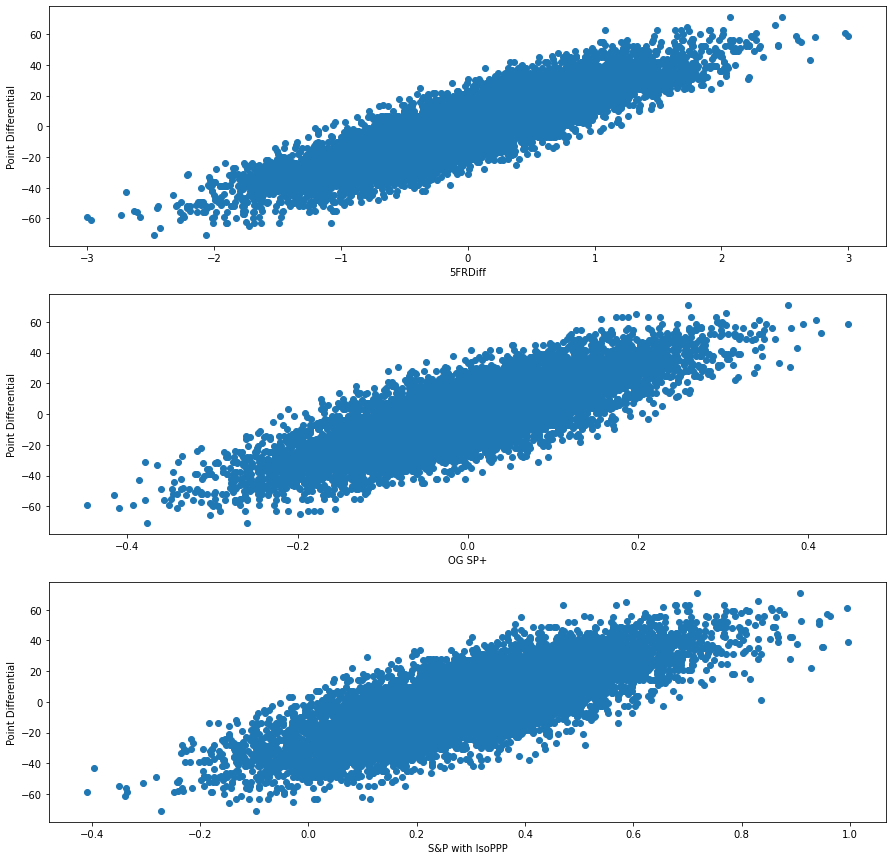

In [19]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [20]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.95089456165382


In [21]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.949951,0.772435
S&PIsoPPPDiff,0.949951,1.000000,0.803297
PtsDiff,0.772435,0.803297,1.000000


In [22]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742,0.841788,2.004783
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742,0.841788,2.004783
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487,0.763294,0.190932
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062


In [23]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [24]:
# outliers

In [25]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742,0.841788,2.004783
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062
6,UCLA,2012,322430242,49.0,25.0,0.361313,69,0.536232,0.130435,9.173913,...,0.200629,-0.592460,1.088340,1.312536,0.200629,-0.592460,5.281189,0.609177,0.820815,1.193323
7,Rice,2012,322430242,24.0,-25.0,0.638687,78,0.423077,0.089744,5.141026,...,-0.200629,0.592460,-1.088340,-1.312536,-0.200629,0.592460,4.672011,-0.609177,0.820815,1.193323


In [26]:
# Linear Regression Model
# from sklearn.linear_model import LinearRegression, SGDClassifier
# from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [27]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data["PtsDiff"][:, np.newaxis])

# print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Mean Pred Score: -0.006779026240110397
Pred Std Dev: 17.334339141845703
Mean Abs Error: 8.303621022081053
Mdn Abs Error: 6.895115852355957
R-squared: 0.747751974439467
Adj R-squared: 0.7476301154899208



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.743084,0.558093,0.461357,0.788025,0.589375,0.603763,0.982371,0.498222,0.770034,...,0.187454,0.121878,-0.017255,-0.220346,-0.187454,0.121878,-0.017255,0.864775,0.866611,0.865523
OffSRDiff,0.743084,1.000000,0.453441,0.257084,0.678621,0.341751,0.403038,0.744917,0.754259,0.696001,...,0.148494,0.090442,-0.047421,-0.155454,-0.148494,0.090442,-0.047421,0.956781,0.958964,0.955136
OffERDiff,0.558093,0.453441,1.000000,0.165590,0.506878,0.284392,0.310499,0.543652,0.317230,0.802655,...,0.120783,0.030103,-0.061594,-0.129476,-0.120783,0.030103,-0.061594,0.529424,0.530617,0.531916
FPDiff,0.461357,0.257084,0.165590,1.000000,0.583204,0.076593,0.071323,0.434861,0.017919,0.223790,...,0.080992,0.428024,0.290681,-0.156867,-0.080992,0.428024,0.290681,0.342711,0.344806,0.347262
OppRateDiff,0.788025,0.678621,0.506878,0.583204,1.000000,0.179129,0.199284,0.790214,0.246351,0.668843,...,0.171717,0.119621,-0.010852,-0.194509,-0.171717,0.119621,-0.010852,0.762180,0.763936,0.764777
OppEffDiff,0.589375,0.341751,0.284392,0.076593,0.179129,1.000000,0.748726,0.583845,0.426961,0.412629,...,0.096531,0.021977,-0.028593,-0.108562,-0.096531,0.021977,-0.028593,0.470303,0.471979,0.464687
OppPPDDiff,0.603763,0.403038,0.310499,0.071323,0.199284,0.748726,1.000000,0.613354,0.510797,0.463609,...,0.092925,0.015361,-0.038342,-0.117125,-0.092925,0.015361,-0.038342,0.571373,0.571788,0.563222
PPDDiff,0.982371,0.744917,0.543652,0.434861,0.790214,0.583845,0.613354,1.000000,0.498896,0.755986,...,0.182537,0.111739,-0.030805,-0.213763,-0.182537,0.111739,-0.030805,0.867465,0.869306,0.867431
OppSRDiff,0.498222,0.754259,0.317230,0.017919,0.246351,0.426961,0.510797,0.498896,1.000000,0.509719,...,0.074522,0.041386,-0.045845,-0.072091,-0.074522,0.041386,-0.045845,0.727056,0.729246,0.723362
YPPDiff,0.770034,0.696001,0.802655,0.223790,0.668843,0.412629,0.463609,0.755986,0.509719,1.000000,...,0.165037,0.026036,-0.072270,-0.172839,-0.165037,0.026036,-0.072270,0.779631,0.781361,0.779433


In [28]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.753074,0.743084,0.758586,0.904311,0.346892,0.423487,0.864775,0.866611,0.865523
ActPts,0.753074,1.000000,0.554813,0.563420,0.684288,0.267380,0.318762,0.649197,0.650888,0.651029
Eff,0.743084,0.554813,1.000000,0.686092,0.778919,0.341938,0.268084,0.956781,0.958964,0.955136
Expl,0.758586,0.563420,0.686092,1.000000,0.741857,0.285756,0.259696,0.768872,0.770629,0.768396
FinDrv,0.904311,0.684288,0.778919,0.741857,1.000000,0.332343,0.397065,0.915578,0.917301,0.912041
FldPos,0.346892,0.267380,0.341938,0.285756,0.332343,1.000000,0.075082,0.380110,0.381060,0.379119
Trnovr,0.423487,0.318762,0.268084,0.259696,0.397065,0.075082,1.000000,0.421928,0.380191,0.382936
5FR,0.864775,0.649197,0.956781,0.768872,0.915578,0.380110,0.421928,1.000000,0.997732,0.993672
5FRDiff,0.866611,0.650888,0.958964,0.770629,0.917301,0.381060,0.380191,0.997732,1.000000,0.995813
PredPtsDiff,0.865523,0.651029,0.955136,0.768396,0.912041,0.379119,0.382936,0.993672,0.995813,1.000000


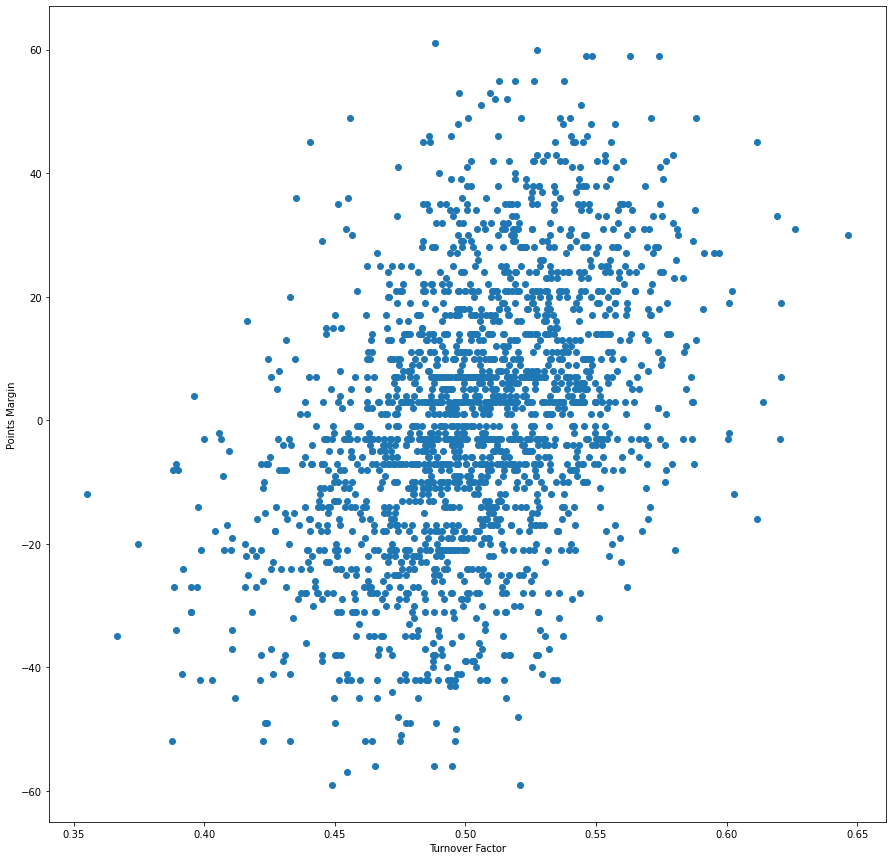

In [29]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

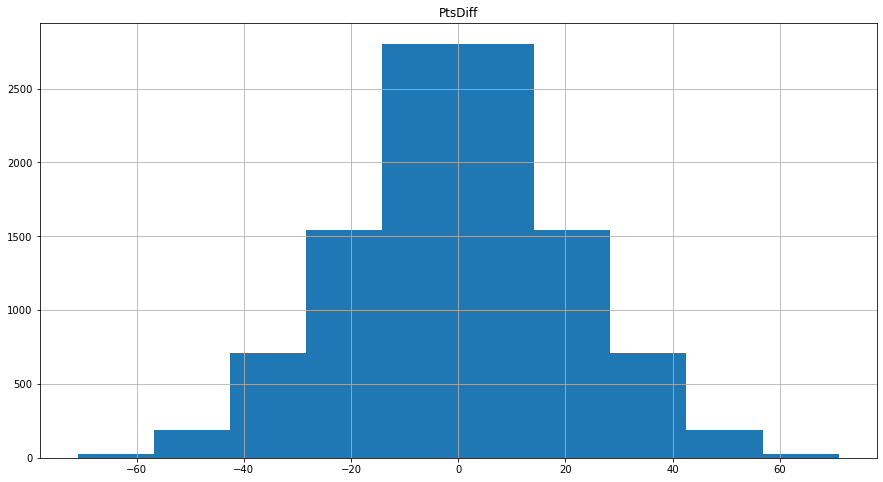

In [30]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

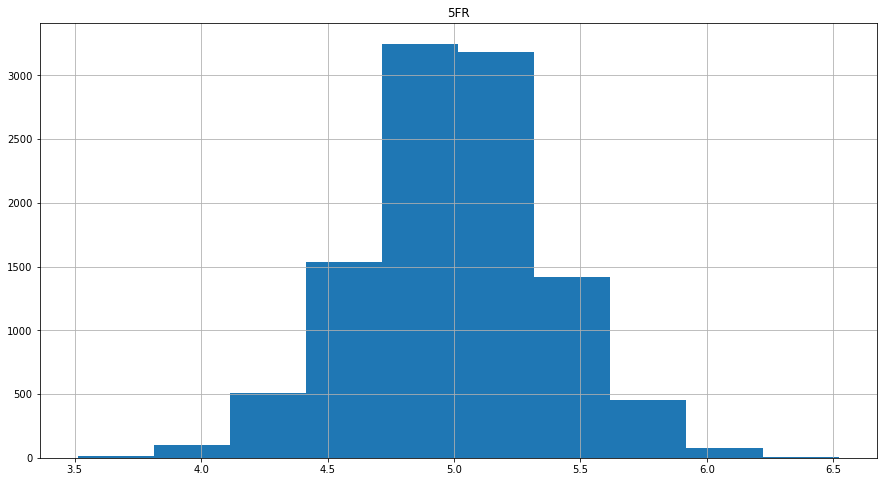

In [31]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

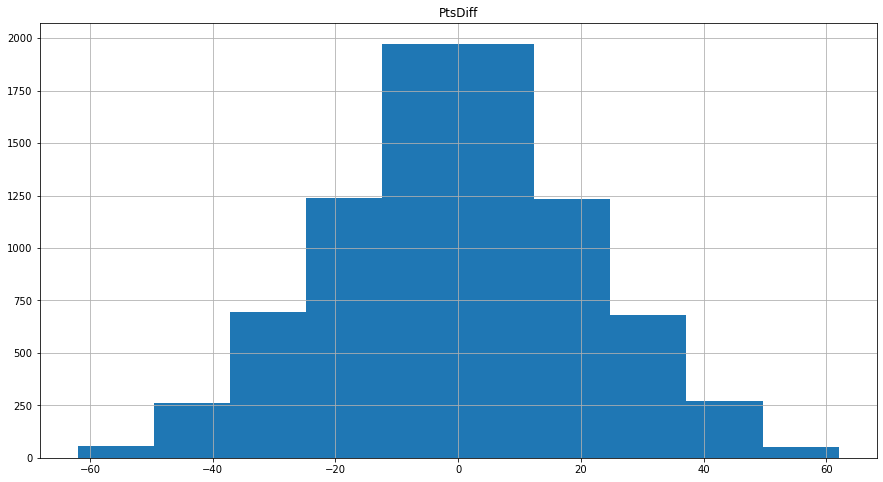

In [32]:
train_data.hist(column='PtsDiff', figsize=(15,8));

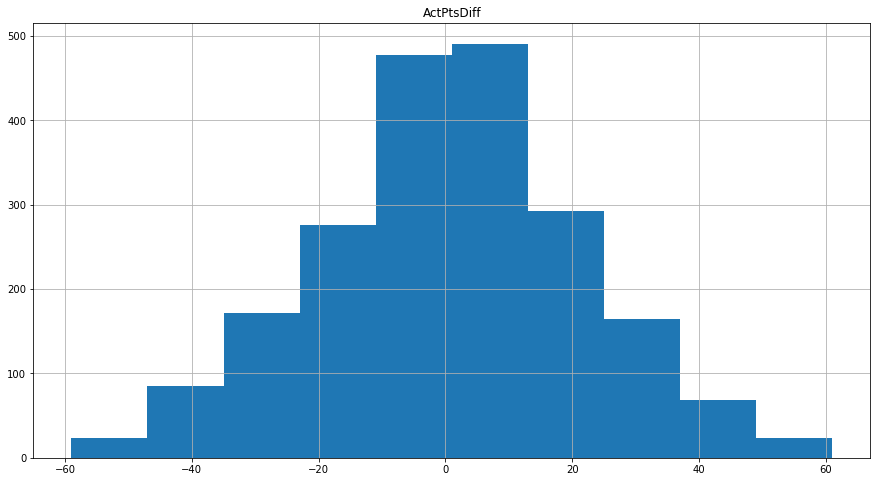

In [33]:
test.hist(column='ActPtsDiff', figsize=(15,8));

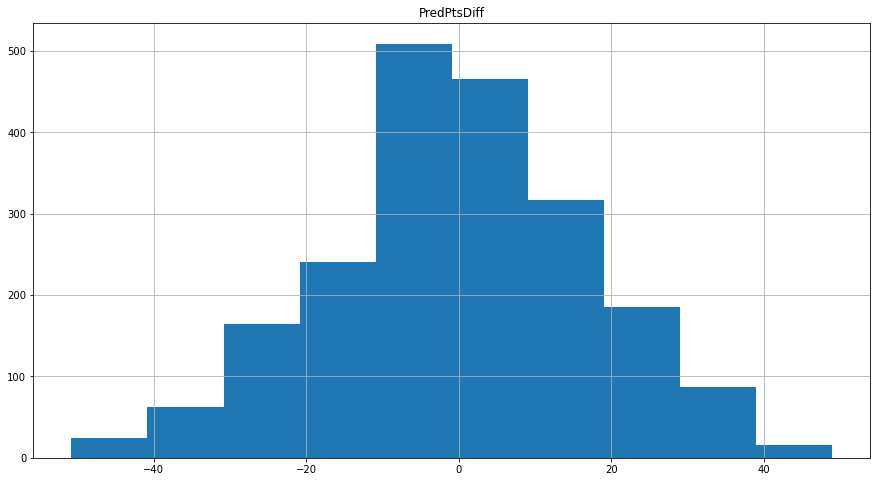

In [34]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [35]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [36]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5 (exact value: -4.843801975250244)
Z score: -0.2790428102016449
Win Prob for Virginia Tech: 39.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [37]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -2 (exact value: -2.106095314025879)
Z score: -0.12110737711191177
Win Prob for Georgia Tech: 45.18%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.396825,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,5.000088,-0.045422
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.370968,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.045510,0.045422


In [38]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2 (exact value: -2.3964009284973145)
Z score: -0.13785479962825775
Win Prob for Georgia Tech: 44.52%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.487500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.036152,0.073397
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.473684,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.962754,-0.073397


In [39]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 3 (exact value: 2.6223301887512207)
Z score: 0.15167057514190674
Win Prob for Mississippi State: 56.03%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.422535,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.967197,-0.040973
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.413793,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,5.008170,0.040973


In [40]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3 (exact value: -2.641535997390747)
Z score: -0.15199638903141022
Win Prob for Texas A&M: 43.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.466667,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.081001,0.162617
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.423077,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.918383,-0.162617


In [41]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(np.array([[tester['5FRDiff'].mean()]]))
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.949622,13,12.0,1.0
2,Alabama,0.934667,12,11.0,1.0
3,LSU,0.920400,13,12.0,1.0
4,Clemson,0.906666,13,12.0,1.0
5,Oklahoma,0.891412,13,12.0,1.0
6,Oregon,0.838922,13,11.0,2.0
7,Wisconsin,0.838922,13,11.0,2.0
8,Louisiana,0.832681,13,11.0,2.0
9,Utah,0.823380,13,11.0,2.0
10,Appalachian State,0.770875,13,10.0,3.0


In [42]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
53,LSU,10.710577,2.289423
77,Ohio State,10.685058,2.314942
78,Oklahoma,9.611512,3.388488
75,Notre Dame,8.406119,3.593881
115,Utah,8.252322,4.747678
110,UCF,7.930312,4.069688
0,Air Force,7.850334,4.149666
128,Wisconsin,7.846827,5.153173
56,Memphis,7.665385,5.334615
18,Central Michigan,7.629218,5.370782


In [43]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2022):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.424575,1.0
1,Alabama,2012,5.399574,2.0
2,Arizona State,2012,5.336245,3.0
3,Notre Dame,2012,5.278415,4.0
4,Georgia,2012,5.248564,5.0
5,Fresno State,2012,5.243495,6.0
6,Oklahoma,2012,5.240594,7.0
7,Boise State,2012,5.222013,8.0
8,BYU,2012,5.219703,9.0
9,Ohio State,2012,5.215022,10.0


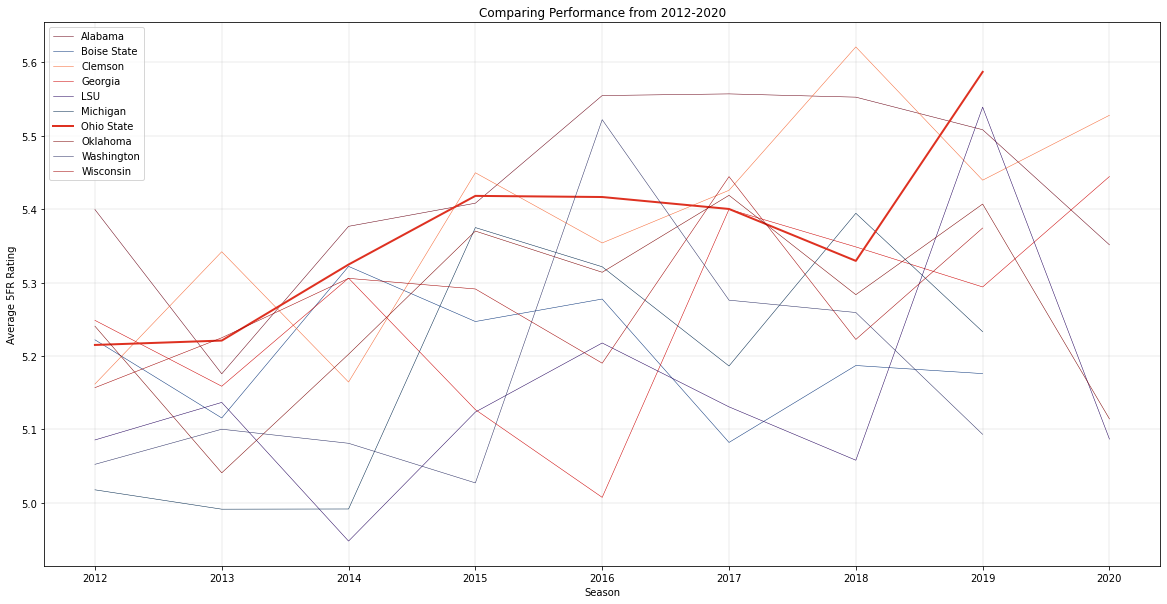

In [44]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [45]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.431628
1,Clemson,5.387395
2,Ohio State,5.364059
3,Wisconsin,5.276272
4,Oklahoma,5.265740
5,Georgia,5.259411
6,Appalachian State,5.213652
7,Boise State,5.203652
8,Michigan,5.188835
9,Notre Dame,5.186647


In [46]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1028,Air Force,2020,5.821850,1.0
1029,BYU,2020,5.761986,2.0
768,Clemson,2018,5.621188,1.0
1030,Appalachian State,2020,5.596522,3.0
898,Ohio State,2019,5.587154,1.0
638,Alabama,2017,5.557155,1.0
510,Alabama,2016,5.554906,1.0
769,Alabama,2018,5.552709,2.0
126,Florida State,2013,5.542778,1.0
899,LSU,2019,5.539098,2.0


In [47]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
276,Georgia Tech,2014,5.163879,23.0
1055,Georgia Tech,2020,5.096640,28.0
53,Georgia Tech,2012,5.034246,54.0
723,Georgia Tech,2017,4.959406,86.0
207,Georgia Tech,2013,4.915070,82.0
857,Georgia Tech,2018,4.905974,90.0
598,Georgia Tech,2016,4.900641,89.0
467,Georgia Tech,2015,4.895461,86.0
998,Georgia Tech,2019,4.846594,101.0


In [50]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2021):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323290278.0,Fresno State,2012.0,Air Force,8.0
8,332502005.0,Utah State,2013.0,Air Force,1.0
9,332560068.0,Boise State,2013.0,Air Force,2.0


In [56]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict(np.array([[ffr_diff]]))
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2021, 0, -1, True)

[0.135927390616516, -19.05377197265625]

In [57]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,5.169817,0.617390,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,3.534838,0.580945,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-9.471688,0.292526,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,1.892913,0.543633,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-10.383008,0.274722,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-3.410500,0.422165,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-2.106095,0.451803,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,7.827919,0.674357,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,5.072348,0.615243,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,3.534838,0.580945,True,BYU,BYU,Hawai'i,Hawai'i


In [58]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 20-20
ML Record: 25-15


In [59]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 2 (exact value: 2.1563026905059814)
Z score: 0.12478592991828918
Win Prob for Virginia: 54.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.432432,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,4.950479,-0.058095
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.381818,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,5.008574,0.058095


In [60]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10 (exact value: 10.051643371582031)
Z score: 0.5802599191665649
Win Prob for North Carolina: 71.91%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.457447,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.194658,0.367629
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.396226,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.827029,-0.367629


In [61]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19 (exact value: 19.04071617126465)
Z score: 1.098830223083496
Win Prob for Pittsburgh: 86.41%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.362319,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.368209,0.771879
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.204082,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.596329,-0.771879


In [62]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -11 (exact value: -11.171915054321289)
Z score: -0.644105076789856
Win Prob for Auburn: 25.98%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.453333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.23668,0.49139
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.338710,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.74529,-0.49139


In [63]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 33 (exact value: 33.45758819580078)
Z score: 1.9305245876312256
Win Prob for Georgia: 97.32%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,72,0.472222,0.138889,6.847222,...,0.688628,NaN,0.831684,0.594622,-0.688628,-0.660553,0.831684,0.594622,5.707078,1.386026
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,58,0.224138,0.034483,2.396552,...,-0.688628,NaN,-0.831684,-0.594622,0.688628,0.660553,-0.831684,-0.594622,4.321052,-1.386026


In [64]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

In [ ]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
# plt.figure(figsize=(15, 8))
# plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
# plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
# plt.yticks(np.arange(0, 100, step=10))
# plt.grid(linestyle='-', linewidth=0.5)
# plt.title("Georgia Tech Performance vs Predictions in 2019")
# plt.xlabel('2019 Opponent');
# plt.ylabel('Win Probability %')
# plt.legend();

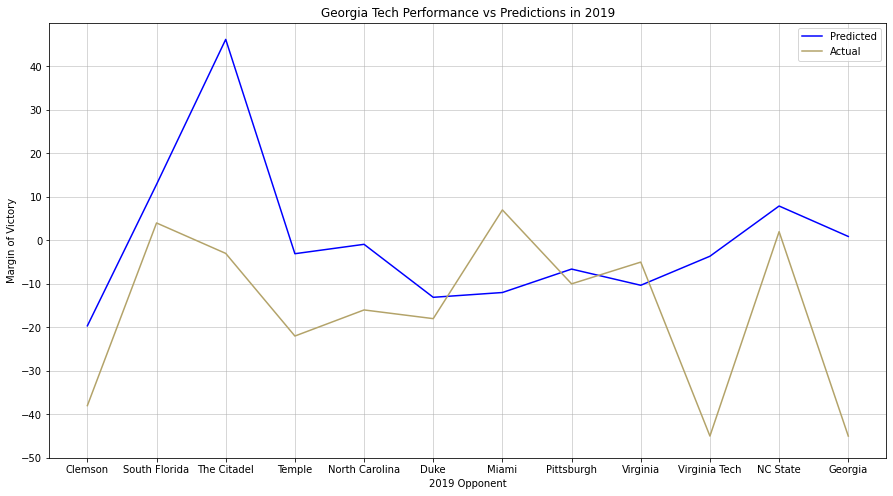

In [67]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 38 (exact value: 38.17737579345703)
Z score: 2.2028040885925293
Win Prob for Georgia Tech: 98.62%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -4 (exact value: -3.815310478210449)
Z score: -0.21971021592617035
Win Prob for South Florida: 41.30%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 4 (exact value: 3.5348384380340576)
Z score: 0.20431222021579742
Win Prob for Pittsburgh: 58.09%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 34 (exact value: 34.202125549316406)
Z score: 1.9734761714935303
Win Prob for Clemson: 97.58%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 33 (exact value: 33.45758819580078)
Z score: 1.

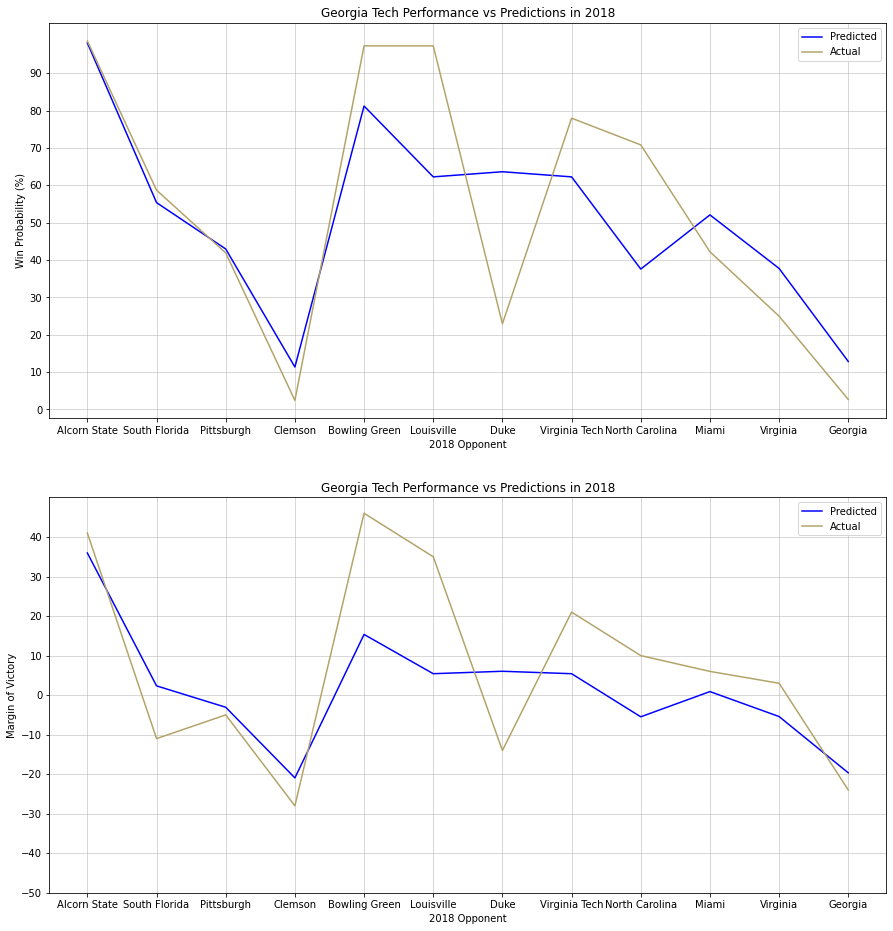

In [68]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

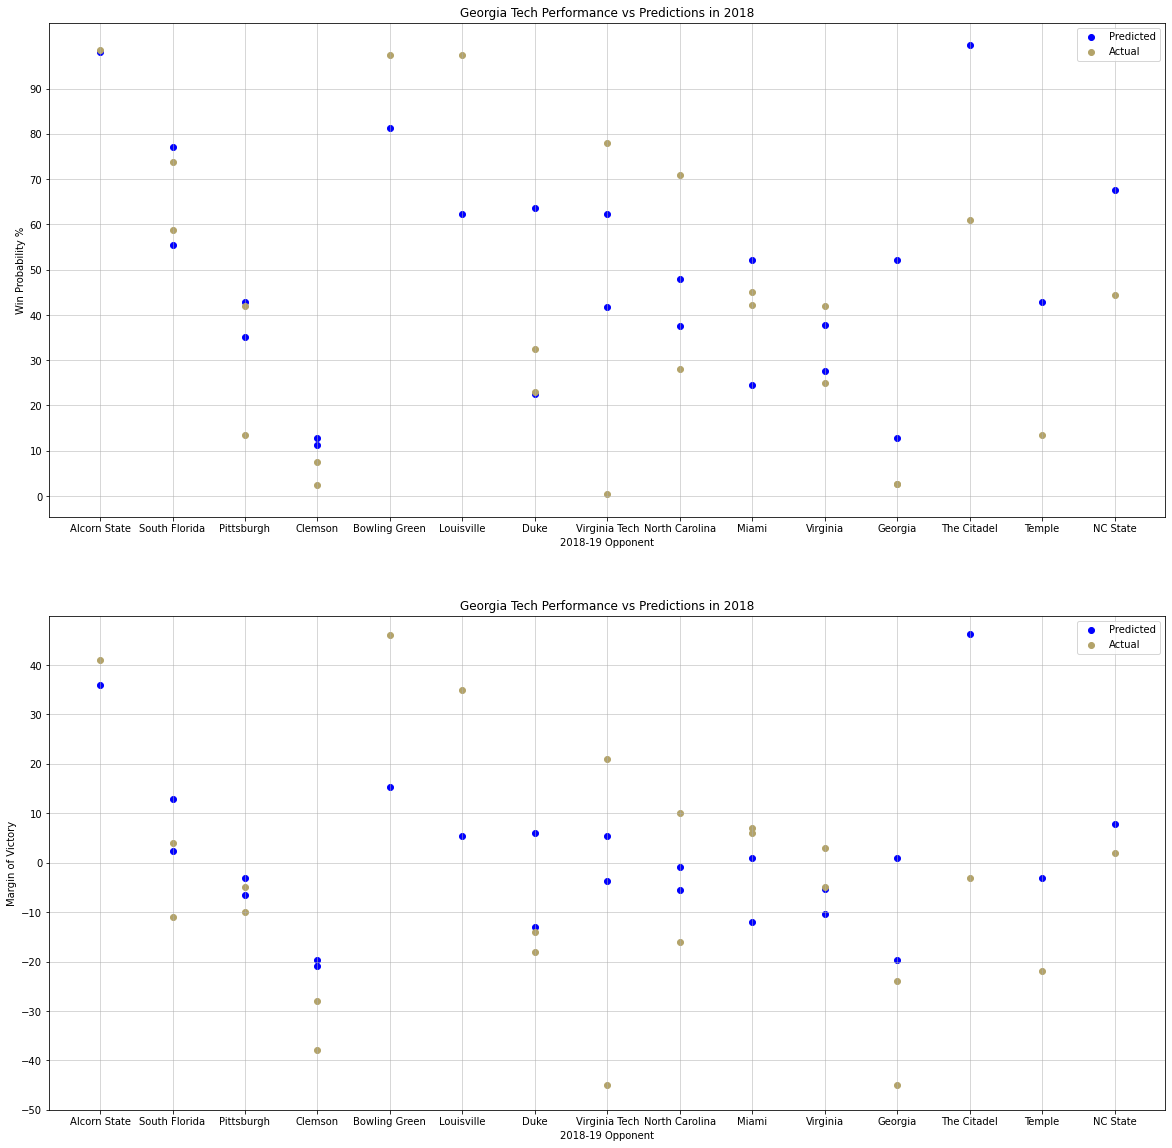

In [69]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [70]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.589968,0.433165,0.413175,0.319913,0.257924,0.252010,0.304181,0.266783
2013,0.589968,1.000000,0.509891,0.345305,0.232832,0.259887,0.200100,0.288702,0.023358
2014,0.433165,0.509891,1.000000,0.539923,0.377669,0.301211,0.283678,0.327604,0.130324
2015,0.413175,0.345305,0.539923,1.000000,0.605279,0.423373,0.338788,0.365003,0.323557
2016,0.319913,0.232832,0.377669,0.605279,1.000000,0.533999,0.343896,0.481320,0.298611
2017,0.257924,0.259887,0.301211,0.423373,0.533999,1.000000,0.597994,0.492423,0.329443
2018,0.252010,0.200100,0.283678,0.338788,0.343896,0.597994,1.000000,0.559105,0.419068
2019,0.304181,0.288702,0.327604,0.365003,0.481320,0.492423,0.559105,1.000000,0.418965
2020,0.266783,0.023358,0.130324,0.323557,0.298611,0.329443,0.419068,0.418965,1.000000


In [71]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.163098166219526


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,27.236021,-10.492462
1,2020,Georgia Tech,UCF,Home,42.671801,-3.209057
2,2020,Georgia Tech,Syracuse,Away,53.677233,1.606833
3,2020,Georgia Tech,Louisville,Home,51.031464,0.441450
4,2020,Georgia Tech,Clemson,Home,9.782902,-22.437784
5,2020,Georgia Tech,Boston College,Away,47.516245,-1.073129
6,2020,Georgia Tech,Notre Dame,Home,26.575277,-10.853039
7,2020,Georgia Tech,Pittsburgh,Home,38.334026,-5.150219
8,2020,Georgia Tech,Miami,Away,25.163335,-11.596111
9,2020,Georgia Tech,Duke,Home,46.805268,-1.396401


In [72]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.529284661601686


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,25.352189,-11.493650
1,2019,Georgia Tech,South Florida,Home,56.642521,2.892913
2,2019,Georgia Tech,The Citadel,Home,97.660596,34.457588
3,2019,Georgia Tech,Temple,Away,39.666026,-4.534838
4,2019,Georgia Tech,North Carolina,Home,58.821579,3.858046
5,2019,Georgia Tech,Duke,Away,42.760503,-3.156303
6,2019,Georgia Tech,Miami,Away,39.666026,-4.534838
7,2019,Georgia Tech,Pittsburgh,Home,48.628059,-0.603015
8,2019,Georgia Tech,Virginia,Away,39.666026,-4.534838
9,2019,Georgia Tech,Virginia Tech,Home,47.471666,-1.106095


In [73]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 19820


In [74]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [96]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 604 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 597 games with betting lines for 2013 season.
[Simulation] Creating projections for 597 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 619 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 571 games with betting lines for 2014 season.
[Simulation] Creating projections for 571 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 662 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 632 games with betting lines for 2015 season.
[Simulation] Creating projections for 632 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,449,148,0,0.752094
1,ATS,2013,337,253,7,0.564489
0,ML,2014,432,139,0,0.756567
1,ATS,2014,348,209,14,0.609457
0,ML,2015,490,142,0,0.775316
1,ATS,2015,377,238,17,0.596519
0,ML,2016,481,144,0,0.769600
1,ATS,2016,381,227,17,0.609600
0,ML,2017,515,167,0,0.755132
1,ATS,2017,401,262,19,0.587977


In [97]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $3550.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,337,253,7,0.564489,2985,293.5,18.343750,0.098325
1,ATS,2014,348,209,14,0.609457,2855,590.5,36.906250,0.206830
1,ATS,2015,377,238,17,0.596519,3160,576.0,38.400000,0.182278
1,ATS,2016,381,227,17,0.609600,3125,656.5,43.766667,0.210080
1,ATS,2017,401,262,19,0.587977,3410,564.0,37.600000,0.165396
1,ATS,2018,349,251,17,0.565640,3085,364.5,24.300000,0.118152
1,ATS,2019,386,279,11,0.571006,3380,395.5,26.366667,0.117012
1,ATS,2020,66,40,1,0.616822,535,110.0,7.333333,0.205607


In [98]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7569797845890404
Avg ATS Win %: 0.5901887841918008


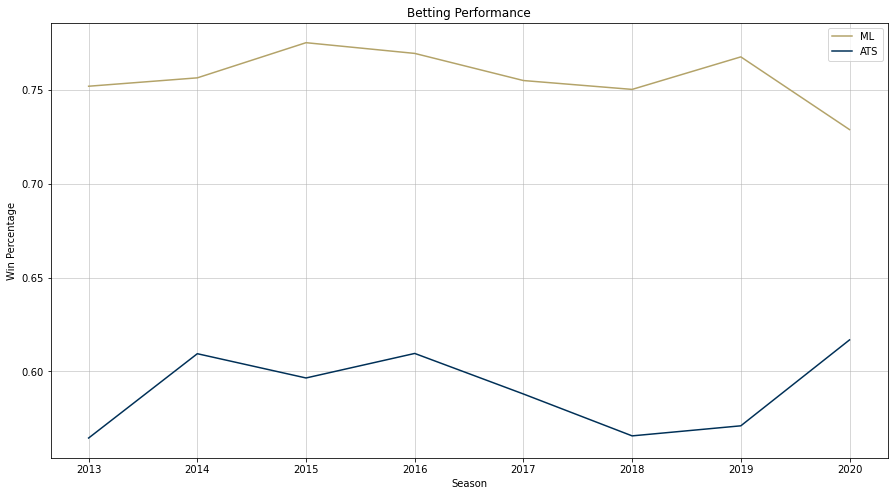

In [99]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [79]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [80]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6362806440726732, 6.034838438034058]

In [81]:
# generate_win_prob(401135295, 2019)

In [82]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [83]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,1.347937,1
77,Ohio State,1.168829,2
2,Alabama,1.103450,3
78,Oklahoma,0.870543,4
9,Auburn,0.861739,5
127,Wisconsin,0.858959,6
34,Georgia,0.839162,7
21,Clemson,0.818303,8
114,Utah,0.776542,9
82,Oregon,0.729579,10


In [84]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 9 (exact value: 9.492462158203125)
Z score: 0.5480013489723206
Win Prob for Georgia Tech: 70.82%
---


[0.7081545117124857, 3.0]

In [85]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 9 (exact value: 9.176207542419434)
Z score: 0.5297569036483765
Win Prob for UCF: 70.19%
---


[0.7018597555184842, 28.0]

In [86]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -2 (exact value: -2.3964009284973145)
Z score: -0.13785479962825775
Win Prob for Syracuse: 44.52%
---


[0.44517758695677223, 17.0]

In [87]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 13 (exact value: 12.539332389831543)
Z score: 0.7237721085548401
Win Prob for Georgia Tech: 76.54%
---


[0.7653971723445935, 19.0]

In [88]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5248375518850603, 1.0731292366981506]

In [89]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,8.827919,0.694857,False,Miami,Virginia
0,Texas,Baylor,10.5,5.672117,0.628397,False,Texas,Baylor
0,BYU,Texas State,28.0,11.368275,0.744157,False,BYU,Texas State
0,Michigan,Minnesota,3.0,10.492462,0.727640,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,12.018976,0.756082,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,23.883255,0.915928,False,Ohio State,Nebraska


In [90]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020


In [91]:
sched_2020 = generate_schedule_analysis(team = "Georgia Tech", year = 2020)
sched_2020

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 9 (exact value: 9.492462158203125)
Z score: 0.5480013489723206
Win Prob for Georgia Tech: 70.82%
---
Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 9 (exact value: 9.176207542419434)
Z score: 0.5297569036483765
Win Prob for UCF: 70.19%
---
Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -2 (exact value: -2.3964009284973145)
Z score: -0.13785479962825775
Win Prob for Syracuse: 44.52%
---
Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 13 (exact value: 12.539332389831543)
Z score: 0.7237721085548401
Win Prob for Georgia Tech: 76.54%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 66.0
Proj MOV: Clemson by 38 (exact value: 38.05359649658203)
Z score: 2.1956634521484375
Win Prob for Clemson: 98.59%
---
Game: Geo

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401234563,2020,Georgia Tech,Florida State,Away,-11.661347,25.043481,3.0,70.815451
1,401234568,2020,Georgia Tech,UCF,Home,4.656303,60.603837,-28.0,29.814024
2,401234594,2020,Georgia Tech,Syracuse,Away,-6.034838,36.371936,-17.0,55.482241
3,401234601,2020,Georgia Tech,Louisville,Home,4.656303,60.603837,19.0,76.539717
4,401234610,2020,Georgia Tech,Clemson,Home,-16.478149,17.100120,-66.0,1.405802
5,401234617,2020,Georgia Tech,Boston College,Away,-7.669817,32.893537,-21.0,37.762375
6,401234626,2020,Georgia Tech,Notre Dame,Home,-0.910500,47.921067,-18.0,16.107792
7,401234652,2020,Georgia Tech,Duke,Home,4.392913,60.018024,23.0,77.087521
8,401234659,2020,Georgia Tech,NC State,Away,-0.103599,49.745971,-10.0,54.819701
9,401261245,2020,Georgia Tech,Pittsburgh,Home,0.103599,50.254029,-14.0,32.564330


In [92]:
print(f"Expected 2nd order wins: {sched_2020.PostGameWinProb.sum() / 100}")

Expected 2nd order wins: 4.523989546151513


In [93]:
model.save_model('pgwp_model.model')

In [95]:
opp_2021_df = pd.DataFrame(data={
    "Team" : ["Northern Illinois","Kennesaw State","Clemson","North Carolina","Pittsburgh","Duke","Virginia","Virginia Tech","Miami","Boston College","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Away","Neutral","Home","Away","Away","Home","Away","Home","Away","Home"]
})
georgia_tech_2021 = generate_schedule_predictions("Georgia Tech", opp_2021_df, 2021)
print(f"Expected 2nd order wins: {georgia_tech_2021.PredWinProb.sum() / 100}")
georgia_tech_2021

Expected 2nd order wins: 5.170514917562431


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2021,Georgia Tech,Northern Illinois,Home,76.583267,12.563933
1,2021,Georgia Tech,Kennesaw State,Home,99.802793,49.961098
2,2021,Georgia Tech,Clemson,Away,9.364496,-22.850952
3,2021,Georgia Tech,North Carolina,Neutral,28.036350,-10.091239
4,2021,Georgia Tech,Pittsburgh,Home,46.805268,-1.396401
5,2021,Georgia Tech,Duke,Away,56.435544,2.815310
6,2021,Georgia Tech,Virginia,Away,39.666026,-4.534838
7,2021,Georgia Tech,Virginia Tech,Home,44.485618,-2.410500
8,2021,Georgia Tech,Miami,Away,34.015924,-7.135464
9,2021,Georgia Tech,Boston College,Home,44.485618,-2.410500
